In [ ]:
# Install timm for state-of-the-art image models, including vision transformers

!pip install timm
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 3.8 MB/s 
     |████████████████████████████████| 182 kB 32.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 6.4 MB/s 
     |████████████████████████████████| 31.2 MB 3.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import timm

from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from glob import glob

import torchvision.transforms as transforms
import torchvision.io as io
import torch
from torch.utils.data import random_split, DataLoader, Dataset
import torch.optim as optim

import copy
import time
from tqdm import tqdm

from sklearn.metrics import mean_squared_error as mse, confusion_matrix

In [ ]:
dataset_path = "/content/drive/MyDrive/CIS 419 Final Project/pawpularity-score-dataset/"
plots_path = "/content/drive/MyDrive/CIS 419 Final Project/plots/"

In [ ]:
train_df = pd.read_csv(dataset_path + "/train.csv")
print (f"Number of IDs in the training df: {len(train_df.index)}")
train_df.head()

Number of IDs in the training df: 9912


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [ ]:
# First, create an index of image files that are not duplicates.
# Duplicate images will have format 'imageID (1)'

images = glob(dataset_path + "/train/*.jpg")
print (f"Train directory contains {len(images)} images")
duplicates_removed = [image for image in images if " " not in image.split("/")[-1]]

print (f"Leaves {len(duplicates_removed)} images when duplicates removed")

Train directory contains 9912 images
Leaves 9912 images when duplicates removed


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = 224
class Pawpularity(Dataset):
  def __init__ (self, img_paths, train_df):
    self.img_paths = img_paths # take only 500 images atm

    self.preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # these values come straight from ImageNet
    ])

    train_df = train_df.set_index('Id')
    image_ids = [img_path.split("/")[-1].split(".")[0] for img_path in self.img_paths]

    self.labels = train_df.loc[image_ids, "Pawpularity"].to_numpy()

  def __len__ (self):
    return len(self.img_paths)

  def __getitem__ (self, ix):
    img = io.read_image(self.img_paths[ix])
    # Originally score labels are in the range 1-100; send them to be between 0 and 99 inclusive
    label = torch.tensor([self.labels[ix]-1]).to(torch.int32)
    img = self.preprocess(img/ 255.)
    return img.float().to(device) , label.long().to(device)

In [ ]:
desired_models = ["resnet50", "vit_base_patch32_224", "swin_large_patch4_window7_224"]

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, pretrained):
  model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
  set_parameter_requires_grad(model, pretrained)
  return model

In [ ]:
batch_size = 16

proportion_of_full_dataset = 1/3

NUM_ROWS_TAKEN = int(len(duplicates_removed) * proportion_of_full_dataset)

dataset = Pawpularity(duplicates_removed[:NUM_ROWS_TAKEN], train_df)
num_train = int(0.7 * NUM_ROWS_TAKEN)
num_val = int(0.1 * NUM_ROWS_TAKEN)
num_test = NUM_ROWS_TAKEN - num_train - num_val
splits = [num_train, num_val, num_test]

train_dataset, val_dataset, test_dataset = random_split(dataset, splits, generator=torch.Generator().manual_seed(42))

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=1, shuffle=True)

#### Method 1
Retraining the Fully Connected Layer of ImageNet-Trained Models

In [ ]:
num_classes = 100

model = initialize_model(desired_models[1], num_classes, True)
print (type(model))
try:
  for param in model.fc.parameters():
    param.requires_grad = True
except:
  for param in model.head.parameters():
    param.requires_grad = True

model = model.to(device)

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)



<class 'timm.models.vision_transformer.VisionTransformer'>
	 head.weight
	 head.bias


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=1e-3)

In [ ]:
dataloaders_dict = {"train": train_dl, "val": val_dl}

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, is_inception=False):
  since = time.time()

  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in tqdm(dataloaders[phase]):
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  # Get model outputs and calculate loss
                  # Special case for inception because in training it has an auxiliary output. In train
                  #   mode we calculate the loss by summing the final output and the auxiliary output
                  #   but in testing we only consider the final output.
                  if is_inception and phase == 'train':
                      # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                      outputs, aux_outputs = model(inputs)
                      loss1 = criterion(outputs, labels)
                      loss2 = criterion(aux_outputs, labels)
                      loss = loss1 + 0.4*loss2
                  else:
                      outputs = model(inputs)
                      loss = criterion(outputs, labels.squeeze_())

                  _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

In [ ]:
model, hist = train_model(model, dataloaders_dict, criterion=loss_fn, optimizer=optimizer, num_epochs=5, is_inception=False)

Epoch 0/4
----------


  5%|▍         | 1/22 [00:49<17:16, 49.34s/it]

torch.Size([16, 1])
tensor(5.4256, grad_fn=<NllLossBackward0>)


  9%|▉         | 2/22 [01:40<16:53, 50.66s/it]

torch.Size([16, 1])
tensor(6.3698, grad_fn=<NllLossBackward0>)


 14%|█▎        | 3/22 [02:33<16:19, 51.54s/it]

torch.Size([16, 1])
tensor(6.4938, grad_fn=<NllLossBackward0>)


 18%|█▊        | 4/22 [03:23<15:17, 50.97s/it]

torch.Size([16, 1])
tensor(6.0455, grad_fn=<NllLossBackward0>)


 23%|██▎       | 5/22 [04:12<14:11, 50.10s/it]

torch.Size([16, 1])
tensor(6.4463, grad_fn=<NllLossBackward0>)


 27%|██▋       | 6/22 [05:00<13:12, 49.52s/it]

torch.Size([16, 1])
tensor(5.4010, grad_fn=<NllLossBackward0>)


 32%|███▏      | 7/22 [05:48<12:17, 49.13s/it]

torch.Size([16, 1])
tensor(6.8105, grad_fn=<NllLossBackward0>)


 32%|███▏      | 7/22 [05:50<12:30, 50.01s/it]


KeyboardInterrupt: ignored

In [ ]:
targets = []
pred = []

with torch.no_grad():
  for input, label in test_dl:
    model.eval()
    predicted_outputs = np.argmax(model(input).cpu().numpy()[0])
    pred.append(predicted_outputs)
    targets.append(label.cpu().numpy()[0])


In [ ]:
print (pred)

[36, 44, 36, 24, 36, 36, 24, 25, 36, 27, 31, 31, 22, 31, 20, 36, 36, 36, 27, 31, 31, 31, 20, 20, 36, 36, 36, 36, 20, 36, 31, 31, 20, 31, 25, 20, 42, 20, 31, 20, 24, 36, 44, 36, 36, 36, 24, 20, 36, 36, 27, 20, 36, 31, 20, 20, 42, 44, 24, 20, 36, 48, 20, 44, 24, 20, 20, 42, 31, 20, 20, 20, 31, 36, 31, 36, 48, 36, 20, 20, 36, 48, 36, 24, 20, 48, 27, 36, 31, 31, 25, 24, 36, 20, 36, 20, 31, 27, 27, 44]


In [ ]:

rmse = np.sqrt(mse(targets, pred))

print (rmse)

25.403346236273677


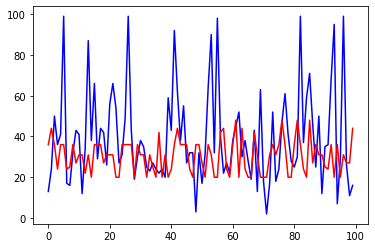

In [ ]:
from matplotlib import pyplot as plt

plt.plot(range(len(pred)), targets, color="blue")
plt.plot(range(len(pred)), pred, color="red")

#### Method 2
Taking what was done on Kaggle: just extract features from the training set, use it to train a SVR model

In [ ]:
model_name = desired_models[2]

model = initialize_model(model_name, num_classes=100, pretrained=True)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


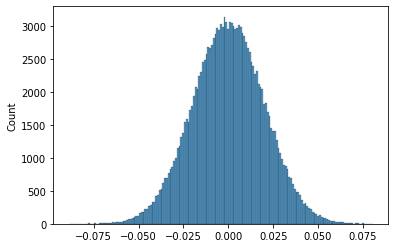

In [ ]:
for param in model.head.parameters():
  params = param.cpu().numpy().flatten()
  if len(np.unique(params)) > 1:
    sns.histplot(params)
  

In [ ]:
model = model

model.eval()

train_features = []
train_targets = []

with torch.no_grad():
  for img,label in tqdm(train_dl):
    train_features.append(model(img).cpu().numpy())
    train_targets.append(label)
  train_features = np.concatenate(train_features, 0)
  train_targets = np.concatenate(train_targets, 0).flatten()

100%|██████████| 145/145 [59:37<00:00, 24.67s/it]


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold

# train_features = StandardScaler().fit_transform(train_features)

# kfold = StratifiedKFold(n_splits=5)

# test_c = [15, 16, 17, 18, 19, 20]

# mean_rmses = []

# for c in test_c:
#   print (c)
#   rmses = []
#   for train_index, test_index in kfold.split(train_features, train_targets):
#     svr = SVR(C=c, kernel="rbf", degree=3, max_iter=4000)
#     svr.fit(train_features[train_index], np.clip(train_targets[train_index], 1, 85))
#     predictions = np.rint(np.clip(svr.predict(train_features[test_index]), 1, 100))
#     rmse = np.sqrt(np.mean(np.square(predictions - train_targets[test_index])))
#     rmses.append(rmse)
#   mean_rmse = np.mean(np.array(rmses))
#   mean_rmses.append(mean_rmse)

# results = dict(zip(test_c, mean_rmses))

# print (results)




# ros = RandomOverSampler(random_state=0)

# train_features, train_targets = ros.fit_resample(train_features, train_targets)

train_features = StandardScaler().fit_transform(train_features)


svr = SVR(C=17, kernel="rbf", degree=3, max_iter=4000)
svr.fit(train_features, np.clip(train_targets, 1, 100))


predictions = np.rint(np.clip(svr.predict(train_features), 1, 100))
print (np.max(predictions))
rmse = np.sqrt(np.mean(np.square(predictions - train_targets)))

print (rmse)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


75.0
13.621378601936774


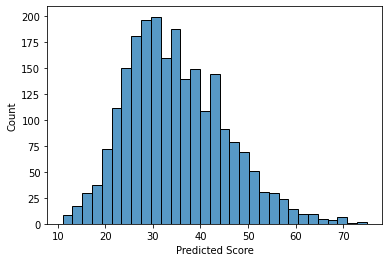

In [ ]:
sns.histplot(predictions)
plt.xlabel("Predicted Score")
plt.savefig(plots_path + "swin_svr_predictions_hist.png", dpi=300)

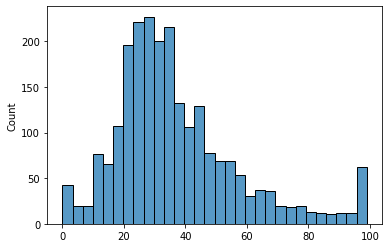

In [ ]:
sns.histplot(train_targets)

Text(87.0, 0.5, 'Predicted Scores')

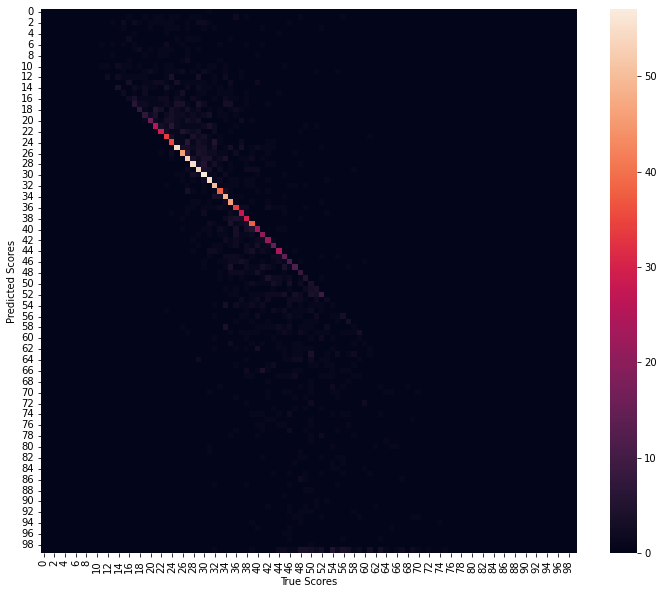

In [ ]:
confusion = confusion_matrix(train_targets, predictions)

plt.figure(figsize=(12, 10))

sns.heatmap(confusion)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")

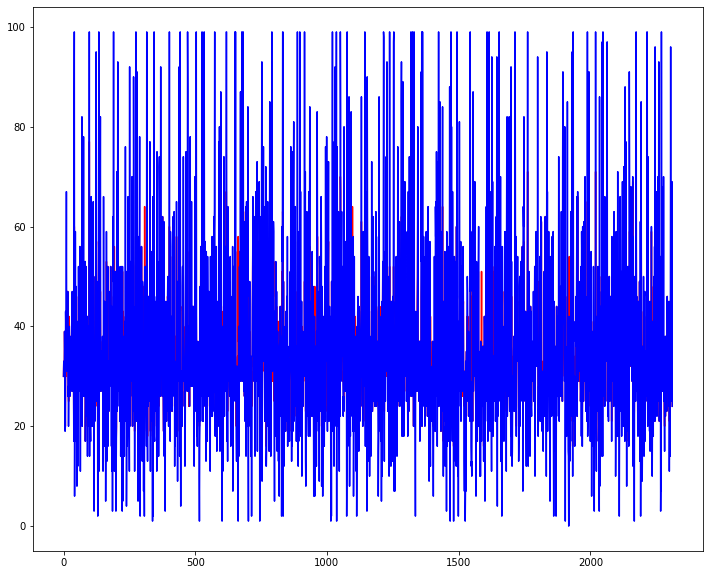

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(range(len(predictions)), predictions, color="red")
plt.plot(range(len(predictions)), train_targets, color="blue")

In [ ]:
model.eval()

test_features = []
test_targets = []

with torch.no_grad():
  for img,label in tqdm(test_dl):
    test_features.append(model(img).cpu().numpy())
    test_targets.append(label)
  test_features = np.concatenate(test_features, 0)
  test_targets = np.concatenate(test_targets, 0).flatten()

100%|██████████| 662/662 [19:59<00:00,  1.81s/it]


In [ ]:
print (test_features[1].shape)

(100,)


In [ ]:
test_features = StandardScaler().fit_transform(test_features)
predictions = np.rint(np.clip(svr.predict(test_features), 1, 100))
test_rmse = np.sqrt(np.mean(np.square(predictions - test_targets)))

print (test_rmse)

18.14751570557215


In [ ]:
print (model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)


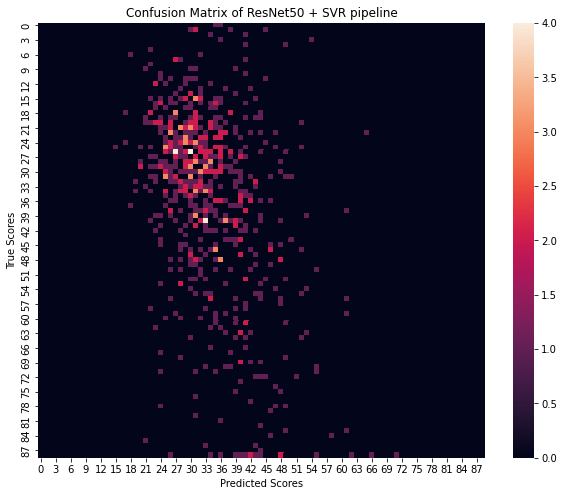

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion = confusion_matrix(test_targets, predictions)

plt.figure(figsize=(10, 8))

sns.heatmap(confusion)
plt.ylabel("True Scores")
plt.xlabel("Predicted Scores")
plt.title("Confusion Matrix of ResNet50 + SVR pipeline")
plt.savefig(plots_path + "confusion_swin_svr.png", dpi=300)

In [ ]:
sns.histplot(predictions)


NameError: ignored

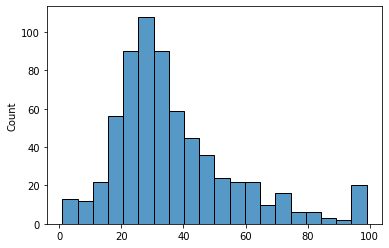

In [ ]:
sns.histplot(test_targets)

#### Method 3 - Finetuning a Regression ViT using BCE Loss and MSE Loss

In [ ]:
model_name = desired_models[1]

model = initialize_model(model_name, num_classes=1, pretrained=True)

try:
  for param in model.fc.parameters():
    param.requires_grad = True
except:
  for param in model.head.parameters():
    param.requires_grad = True

model = model.to(device)

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 head.weight
	 head.bias


In [ ]:
from torch.nn import BCELoss, BCEWithLogitsLoss, MSELoss

loss_fn = BCEWithLogitsLoss()
optimizer = optim.Adam(params_to_update, lr=1e-3)

When output is one-hot encoded
tensor(17.2887)
tensor(1.8959)
tensor(33.9553)
When output is just one node


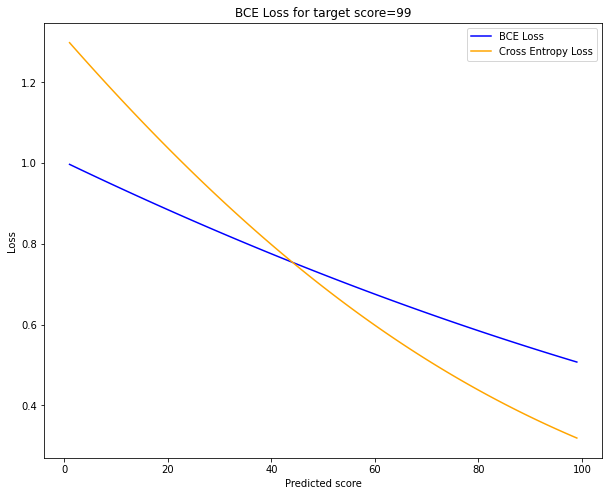

In [ ]:
Experimenting with Loss Functions
from torch.nn import BCELoss
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
from torch.nn import Sigmoid as sigmoid, Softmax as softmax

output = torch.tensor([200, 0.1, 0.3, 0.1, 0.1, 0.1])
target = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

bce = BCELoss()
cross = CrossEntropyLoss()
logit = BCEWithLogitsLoss()

print ("When output is one-hot encoded")

print (bce(sigmoid()(output), target))
print (cross(sigmoid()(output), target))
print (logit(output, target))

logits = []
crosses = []

for out in np.arange(0.01, 1, 0.01).astype("double"):

  output = torch.tensor([out, 1-out]).double()
  target = torch.tensor([1, 0]).double()
  logits.append(bce(sigmoid()(output), target).numpy().flatten()[0])
  crosses.append(cross(output, target).numpy().flatten()[0])

print ("When output is just one node")


sample_output = torch.tensor([12.3, 12.3])
sample_target = torch.tensor([1.0, 0.0])

plt.figure(figsize=(10, 8))
sns.lineplot(x=np.arange(0.01, 1, 0.01)*100, y=logits, label="BCE Loss", color="blue")
plt.xlabel("Predicted score")
plt.ylabel("Loss")
plt.title("BCE Loss for target score=99")
#plt.savefig(plots_path + "bce_loss_graph.png", dpi=300)
sns.lineplot(x=np.arange(0.01, 1, 0.01) * 100, y=crosses, label="Cross Entropy Loss", color="orange")

In [ ]:
input_size = 224
class Pawpularity(Dataset):
  def __init__ (self, img_paths, train_df):
    self.img_paths = img_paths # take only 500 images atm

    self.preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # these values come straight from ImageNet
    ])

    train_df = train_df.set_index('Id')
    image_ids = [img_path.split("/")[-1].split(".")[0] for img_path in self.img_paths]

    self.labels = train_df.loc[image_ids, "Pawpularity"].to_numpy()

  def __len__ (self):
    return len(self.img_paths)

  def __getitem__ (self, ix):
    img = io.read_image(self.img_paths[ix])
    # Originally score labels are in the range 1-100; send them to be between 0 and 99 inclusive
    label = torch.tensor([(self.labels[ix]-1) / 100.0]).to(torch.float32)
    img = self.preprocess(img/ 255.)
    return img.float().to(device) , label.to(device)

batch_size = 16

proportion_of_full_dataset = 1/4

NUM_ROWS_TAKEN = int(len(duplicates_removed) * proportion_of_full_dataset)

dataset = Pawpularity(duplicates_removed[:NUM_ROWS_TAKEN], train_df)
num_train = int(0.7 * NUM_ROWS_TAKEN)
num_val = int(0.1 * NUM_ROWS_TAKEN)
num_test = NUM_ROWS_TAKEN - num_train - num_val
splits = [num_train, num_val, num_test]

train_dataset, val_dataset, test_dataset = random_split(dataset, splits, generator=torch.Generator().manual_seed(42))

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=1, shuffle=True)
  
dataloaders_dict = {"train": train_dl, "val": val_dl}

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, is_inception=False):
  since = time.time()

  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in tqdm(dataloaders[phase]):
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  # Get model outputs and calculate loss
                  # Special case for inception because in training it has an auxiliary output. In train
                  #   mode we calculate the loss by summing the final output and the auxiliary output
                  #   but in testing we only consider the final output.
                  if is_inception and phase == 'train':
                      # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                      outputs, aux_outputs = model(inputs)
                      loss1 = criterion(outputs, labels)
                      loss2 = criterion(aux_outputs, labels)
                      loss = loss1 + 0.4*loss2
                  else:
                      outputs = model(inputs).float()
                      loss = criterion(outputs, labels)
                      print (loss)

                  _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

In [ ]:
model, hist = train_model(model, dataloaders_dict, criterion=loss_fn, optimizer=optimizer, num_epochs=5, is_inception=False)

Epoch 0/4
----------


  1%|          | 1/109 [00:04<08:20,  4.64s/it]

tensor(0.6830, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  2%|▏         | 2/109 [00:10<09:24,  5.28s/it]

tensor(0.6531, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  3%|▎         | 3/109 [00:14<08:21,  4.73s/it]

tensor(0.6830, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  4%|▎         | 4/109 [00:18<07:45,  4.43s/it]

tensor(0.6742, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  5%|▍         | 5/109 [00:22<07:34,  4.37s/it]

tensor(0.7454, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  6%|▌         | 6/109 [00:27<07:48,  4.55s/it]

tensor(0.7062, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  6%|▋         | 7/109 [00:32<07:42,  4.53s/it]

tensor(0.7520, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  7%|▋         | 8/109 [00:35<07:15,  4.31s/it]

tensor(0.8666, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  8%|▊         | 9/109 [00:40<07:29,  4.49s/it]

tensor(0.6564, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  9%|▉         | 10/109 [00:44<07:14,  4.39s/it]

tensor(0.7393, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 10%|█         | 11/109 [00:49<07:13,  4.42s/it]

tensor(0.6689, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 11%|█         | 12/109 [00:53<07:08,  4.42s/it]

tensor(0.6353, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 12%|█▏        | 13/109 [00:57<06:44,  4.22s/it]

tensor(0.7339, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 13%|█▎        | 14/109 [01:01<06:23,  4.04s/it]

tensor(0.7950, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 14%|█▍        | 15/109 [01:07<07:17,  4.65s/it]

tensor(0.7275, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 15%|█▍        | 16/109 [01:11<06:59,  4.51s/it]

tensor(0.7134, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 16%|█▌        | 17/109 [01:15<06:47,  4.42s/it]

tensor(0.6919, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 17%|█▋        | 18/109 [01:20<06:45,  4.45s/it]

tensor(0.7439, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 17%|█▋        | 19/109 [01:24<06:36,  4.40s/it]

tensor(0.6991, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 18%|█▊        | 20/109 [01:29<06:37,  4.47s/it]

tensor(0.6669, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 19%|█▉        | 21/109 [01:33<06:22,  4.35s/it]

tensor(0.7248, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 20%|██        | 22/109 [01:37<06:13,  4.29s/it]

tensor(0.7275, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 21%|██        | 23/109 [01:41<05:59,  4.18s/it]

tensor(0.6628, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 22%|██▏       | 24/109 [01:45<06:07,  4.32s/it]

tensor(0.7448, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 23%|██▎       | 25/109 [01:50<06:20,  4.53s/it]

tensor(0.6542, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 24%|██▍       | 26/109 [01:56<06:48,  4.92s/it]

tensor(0.7247, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 25%|██▍       | 27/109 [02:01<06:43,  4.92s/it]

tensor(0.6617, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 26%|██▌       | 28/109 [02:06<06:31,  4.83s/it]

tensor(0.7026, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 27%|██▋       | 29/109 [02:10<06:06,  4.58s/it]

tensor(0.6736, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 28%|██▊       | 30/109 [02:15<06:06,  4.64s/it]

tensor(0.6806, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 28%|██▊       | 31/109 [02:20<06:14,  4.80s/it]

tensor(0.7310, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 29%|██▉       | 32/109 [02:24<06:00,  4.68s/it]

tensor(0.7205, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 30%|███       | 33/109 [02:29<05:50,  4.61s/it]

tensor(0.6216, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 31%|███       | 34/109 [02:32<05:16,  4.21s/it]

tensor(0.6551, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 32%|███▏      | 35/109 [02:36<05:13,  4.23s/it]

tensor(0.6401, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 33%|███▎      | 36/109 [02:41<05:22,  4.41s/it]

tensor(0.6850, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 34%|███▍      | 37/109 [02:46<05:22,  4.48s/it]

tensor(0.7019, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 35%|███▍      | 38/109 [02:50<05:08,  4.35s/it]

tensor(0.6300, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 36%|███▌      | 39/109 [02:55<05:23,  4.62s/it]

tensor(0.6784, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 37%|███▋      | 40/109 [03:00<05:17,  4.61s/it]

tensor(0.6664, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 38%|███▊      | 41/109 [03:04<05:11,  4.58s/it]

tensor(0.7177, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 39%|███▊      | 42/109 [03:08<05:01,  4.50s/it]

tensor(0.7168, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 39%|███▉      | 43/109 [03:13<05:07,  4.66s/it]

tensor(0.6805, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 40%|████      | 44/109 [03:21<05:52,  5.42s/it]

tensor(0.7231, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 41%|████▏     | 45/109 [03:25<05:23,  5.06s/it]

tensor(0.6775, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 42%|████▏     | 46/109 [03:30<05:20,  5.08s/it]

tensor(0.6609, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 43%|████▎     | 47/109 [03:33<04:40,  4.53s/it]

tensor(0.6706, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 44%|████▍     | 48/109 [03:38<04:49,  4.74s/it]

tensor(0.6658, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 45%|████▍     | 49/109 [03:43<04:32,  4.54s/it]

tensor(0.6297, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 46%|████▌     | 50/109 [03:48<04:38,  4.72s/it]

tensor(0.6429, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 47%|████▋     | 51/109 [03:52<04:22,  4.52s/it]

tensor(0.6484, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 48%|████▊     | 52/109 [03:57<04:34,  4.82s/it]

tensor(0.6893, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 49%|████▊     | 53/109 [04:02<04:26,  4.76s/it]

tensor(0.6858, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 50%|████▉     | 54/109 [04:06<04:11,  4.57s/it]

tensor(0.6768, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 50%|█████     | 55/109 [04:11<04:08,  4.60s/it]

tensor(0.6746, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 51%|█████▏    | 56/109 [04:15<03:52,  4.39s/it]

tensor(0.7093, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 52%|█████▏    | 57/109 [04:19<03:53,  4.49s/it]

tensor(0.6928, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 53%|█████▎    | 58/109 [04:24<03:49,  4.50s/it]

tensor(0.6451, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 54%|█████▍    | 59/109 [04:28<03:44,  4.50s/it]

tensor(0.7517, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 55%|█████▌    | 60/109 [04:32<03:32,  4.34s/it]

tensor(0.6756, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 56%|█████▌    | 61/109 [04:36<03:24,  4.26s/it]

tensor(0.6648, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 57%|█████▋    | 62/109 [04:41<03:26,  4.40s/it]

tensor(0.7597, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 58%|█████▊    | 63/109 [04:45<03:21,  4.39s/it]

tensor(0.6886, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 59%|█████▊    | 64/109 [04:50<03:20,  4.47s/it]

tensor(0.6661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 60%|█████▉    | 65/109 [04:55<03:19,  4.52s/it]

tensor(0.6536, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 61%|██████    | 66/109 [04:59<03:08,  4.37s/it]

tensor(0.7005, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 61%|██████▏   | 67/109 [05:03<03:00,  4.30s/it]

tensor(0.6675, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 62%|██████▏   | 68/109 [05:07<02:54,  4.27s/it]

tensor(0.6680, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 63%|██████▎   | 69/109 [05:11<02:44,  4.11s/it]

tensor(0.6918, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 64%|██████▍   | 70/109 [05:16<02:51,  4.39s/it]

tensor(0.6962, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 65%|██████▌   | 71/109 [05:21<02:57,  4.67s/it]

tensor(0.7407, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 66%|██████▌   | 72/109 [05:25<02:46,  4.49s/it]

tensor(0.6994, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 67%|██████▋   | 73/109 [05:29<02:34,  4.30s/it]

tensor(0.7033, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 68%|██████▊   | 74/109 [05:33<02:30,  4.30s/it]

tensor(0.6803, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 69%|██████▉   | 75/109 [05:38<02:29,  4.40s/it]

tensor(0.6192, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 70%|██████▉   | 76/109 [05:43<02:31,  4.59s/it]

tensor(0.6382, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 71%|███████   | 77/109 [05:47<02:17,  4.31s/it]

tensor(0.6916, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 72%|███████▏  | 78/109 [05:51<02:16,  4.39s/it]

tensor(0.7000, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 72%|███████▏  | 79/109 [05:55<02:06,  4.23s/it]

tensor(0.6660, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 73%|███████▎  | 80/109 [05:58<01:53,  3.92s/it]

tensor(0.6499, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 74%|███████▍  | 81/109 [06:03<01:55,  4.14s/it]

tensor(0.6824, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 75%|███████▌  | 82/109 [06:07<01:53,  4.21s/it]

tensor(0.7148, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 76%|███████▌  | 83/109 [06:12<01:55,  4.44s/it]

tensor(0.6895, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 77%|███████▋  | 84/109 [06:17<01:52,  4.49s/it]

tensor(0.6673, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 78%|███████▊  | 85/109 [06:21<01:45,  4.38s/it]

tensor(0.6862, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 79%|███████▉  | 86/109 [06:25<01:38,  4.29s/it]

tensor(0.6683, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 80%|███████▉  | 87/109 [06:30<01:37,  4.44s/it]

tensor(0.7240, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 81%|████████  | 88/109 [06:34<01:31,  4.37s/it]

tensor(0.6540, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 82%|████████▏ | 89/109 [06:40<01:36,  4.82s/it]

tensor(0.6487, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 83%|████████▎ | 90/109 [06:45<01:33,  4.90s/it]

tensor(0.6413, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 83%|████████▎ | 91/109 [06:49<01:23,  4.64s/it]

tensor(0.6915, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 84%|████████▍ | 92/109 [06:54<01:19,  4.65s/it]

tensor(0.6367, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 85%|████████▌ | 93/109 [06:57<01:08,  4.27s/it]

tensor(0.6623, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 86%|████████▌ | 94/109 [07:01<01:01,  4.07s/it]

tensor(0.6618, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 87%|████████▋ | 95/109 [07:06<01:01,  4.36s/it]

tensor(0.6830, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 88%|████████▊ | 96/109 [07:11<00:58,  4.51s/it]

tensor(0.6536, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 89%|████████▉ | 97/109 [07:14<00:50,  4.20s/it]

tensor(0.6720, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 90%|████████▉ | 98/109 [07:18<00:44,  4.05s/it]

tensor(0.6564, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 91%|█████████ | 99/109 [07:22<00:40,  4.06s/it]

tensor(0.6979, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 92%|█████████▏| 100/109 [07:26<00:37,  4.16s/it]

tensor(0.7270, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 93%|█████████▎| 101/109 [07:31<00:33,  4.19s/it]

tensor(0.7019, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 94%|█████████▎| 102/109 [07:35<00:29,  4.19s/it]

tensor(0.6828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 94%|█████████▍| 103/109 [07:38<00:24,  4.00s/it]

tensor(0.6959, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 95%|█████████▌| 104/109 [07:44<00:22,  4.41s/it]

tensor(0.6093, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 96%|█████████▋| 105/109 [07:48<00:17,  4.30s/it]

tensor(0.7408, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 97%|█████████▋| 106/109 [07:53<00:13,  4.58s/it]

tensor(0.6344, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 98%|█████████▊| 107/109 [07:57<00:08,  4.31s/it]

tensor(0.6255, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 99%|█████████▉| 108/109 [08:00<00:04,  4.11s/it]

tensor(0.6938, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 109/109 [08:02<00:00,  4.43s/it]


tensor(0.5707, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train Loss: 0.6858 Acc: 0.0092


  6%|▋         | 1/16 [00:05<01:24,  5.67s/it]

tensor(0.7059)


 12%|█▎        | 2/16 [00:11<01:17,  5.55s/it]

tensor(0.6471)


 19%|█▉        | 3/16 [00:16<01:13,  5.63s/it]

tensor(0.6942)


 25%|██▌       | 4/16 [00:21<01:04,  5.36s/it]

tensor(0.6431)


 31%|███▏      | 5/16 [00:28<01:06,  6.02s/it]

tensor(0.6371)


 38%|███▊      | 6/16 [00:34<00:58,  5.86s/it]

tensor(0.6400)


 44%|████▍     | 7/16 [00:40<00:52,  5.84s/it]

tensor(0.6316)


 50%|█████     | 8/16 [00:45<00:43,  5.50s/it]

tensor(0.6396)


 56%|█████▋    | 9/16 [00:50<00:38,  5.53s/it]

tensor(0.6462)


 62%|██████▎   | 10/16 [00:56<00:33,  5.53s/it]

tensor(0.6714)


 69%|██████▉   | 11/16 [01:01<00:27,  5.57s/it]

tensor(0.6643)


 75%|███████▌  | 12/16 [01:07<00:22,  5.55s/it]

tensor(0.6834)


 81%|████████▏ | 13/16 [01:12<00:16,  5.50s/it]

tensor(0.6486)


 88%|████████▊ | 14/16 [01:18<00:11,  5.53s/it]

tensor(0.6819)


 94%|█████████▍| 15/16 [01:23<00:05,  5.30s/it]

tensor(0.6849)


100%|██████████| 16/16 [01:25<00:00,  5.33s/it]


tensor(0.6485)
val Loss: 0.6609 Acc: 0.0000

Epoch 1/4
----------


  1%|          | 1/109 [00:02<05:07,  2.84s/it]

tensor(0.6593, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  2%|▏         | 2/109 [00:05<05:05,  2.86s/it]

tensor(0.5934, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  3%|▎         | 3/109 [00:08<05:01,  2.84s/it]

tensor(0.6646, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  4%|▎         | 4/109 [00:11<04:59,  2.86s/it]

tensor(0.6703, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  5%|▍         | 5/109 [00:14<04:55,  2.85s/it]

tensor(0.6202, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  6%|▌         | 6/109 [00:17<04:53,  2.85s/it]

tensor(0.6844, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  6%|▋         | 7/109 [00:20<05:24,  3.18s/it]

tensor(0.6060, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  7%|▋         | 8/109 [00:24<05:44,  3.41s/it]

tensor(0.6395, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  8%|▊         | 9/109 [00:27<05:23,  3.23s/it]

tensor(0.7077, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  9%|▉         | 10/109 [00:30<05:08,  3.12s/it]

tensor(0.6952, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 10%|█         | 11/109 [00:33<04:58,  3.05s/it]

tensor(0.6097, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 11%|█         | 12/109 [00:36<04:50,  2.99s/it]

tensor(0.6574, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 12%|█▏        | 13/109 [00:39<04:43,  2.95s/it]

tensor(0.5836, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 13%|█▎        | 14/109 [00:42<04:37,  2.92s/it]

tensor(0.6400, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 14%|█▍        | 15/109 [00:44<04:32,  2.89s/it]

tensor(0.6866, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 15%|█▍        | 16/109 [00:47<04:27,  2.88s/it]

tensor(0.5988, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 16%|█▌        | 17/109 [00:50<04:24,  2.87s/it]

tensor(0.6789, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 17%|█▋        | 18/109 [00:53<04:20,  2.86s/it]

tensor(0.6184, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 17%|█▋        | 19/109 [00:56<04:17,  2.86s/it]

tensor(0.6542, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 18%|█▊        | 20/109 [00:59<04:14,  2.86s/it]

tensor(0.6814, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 19%|█▉        | 21/109 [01:01<04:12,  2.86s/it]

tensor(0.6636, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 20%|██        | 22/109 [01:04<04:08,  2.86s/it]

tensor(0.6351, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 21%|██        | 23/109 [01:07<04:05,  2.85s/it]

tensor(0.6380, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 22%|██▏       | 24/109 [01:10<04:02,  2.85s/it]

tensor(0.6902, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 23%|██▎       | 25/109 [01:13<03:59,  2.85s/it]

tensor(0.6689, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 24%|██▍       | 26/109 [01:16<03:54,  2.83s/it]

tensor(0.6532, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 25%|██▍       | 27/109 [01:18<03:52,  2.83s/it]

tensor(0.6668, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 26%|██▌       | 28/109 [01:21<03:49,  2.83s/it]

tensor(0.7026, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 27%|██▋       | 29/109 [01:24<03:46,  2.84s/it]

tensor(0.6290, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 28%|██▊       | 30/109 [01:27<03:45,  2.85s/it]

tensor(0.6717, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 28%|██▊       | 31/109 [01:30<03:41,  2.84s/it]

tensor(0.6681, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 29%|██▉       | 32/109 [01:33<03:39,  2.84s/it]

tensor(0.6415, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 30%|███       | 33/109 [01:36<03:36,  2.84s/it]

tensor(0.6260, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 31%|███       | 34/109 [01:38<03:34,  2.86s/it]

tensor(0.6565, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 32%|███▏      | 35/109 [01:41<03:31,  2.86s/it]

tensor(0.6226, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 33%|███▎      | 36/109 [01:44<03:28,  2.86s/it]

tensor(0.5876, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 34%|███▍      | 37/109 [01:47<03:25,  2.85s/it]

tensor(0.6857, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 35%|███▍      | 38/109 [01:50<03:22,  2.85s/it]

tensor(0.6301, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 36%|███▌      | 39/109 [01:53<03:19,  2.85s/it]

tensor(0.5612, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 37%|███▋      | 40/109 [01:56<03:16,  2.85s/it]

tensor(0.6745, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 38%|███▊      | 41/109 [01:58<03:14,  2.87s/it]

tensor(0.7318, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 39%|███▊      | 42/109 [02:01<03:12,  2.87s/it]

tensor(0.6719, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 39%|███▉      | 43/109 [02:04<03:09,  2.87s/it]

tensor(0.6796, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 40%|████      | 44/109 [02:07<03:06,  2.86s/it]

tensor(0.6239, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 41%|████▏     | 45/109 [02:10<03:03,  2.87s/it]

tensor(0.6404, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 42%|████▏     | 46/109 [02:13<02:59,  2.84s/it]

tensor(0.6558, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 43%|████▎     | 47/109 [02:16<02:56,  2.84s/it]

tensor(0.6501, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 44%|████▍     | 48/109 [02:18<02:54,  2.86s/it]

tensor(0.6612, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 45%|████▍     | 49/109 [02:23<03:22,  3.38s/it]

tensor(0.6615, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 46%|████▌     | 50/109 [02:26<03:14,  3.30s/it]

tensor(0.6262, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 47%|████▋     | 51/109 [02:29<03:04,  3.18s/it]

tensor(0.6441, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 48%|████▊     | 52/109 [02:32<02:56,  3.09s/it]

tensor(0.6287, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 49%|████▊     | 53/109 [02:35<02:49,  3.03s/it]

tensor(0.6027, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 50%|████▉     | 54/109 [02:38<02:43,  2.98s/it]

tensor(0.6588, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 50%|█████     | 55/109 [02:41<02:39,  2.95s/it]

tensor(0.6821, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 51%|█████▏    | 56/109 [02:43<02:35,  2.94s/it]

tensor(0.6896, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 52%|█████▏    | 57/109 [02:46<02:31,  2.91s/it]

tensor(0.7170, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 53%|█████▎    | 58/109 [02:49<02:28,  2.90s/it]

tensor(0.6100, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 54%|█████▍    | 59/109 [02:52<02:24,  2.90s/it]

tensor(0.6193, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 55%|█████▌    | 60/109 [02:55<02:22,  2.91s/it]

tensor(0.6502, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 56%|█████▌    | 61/109 [02:58<02:19,  2.90s/it]

tensor(0.6177, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 57%|█████▋    | 62/109 [03:01<02:16,  2.90s/it]

tensor(0.6790, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 58%|█████▊    | 63/109 [03:04<02:12,  2.88s/it]

tensor(0.6307, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 59%|█████▊    | 64/109 [03:07<02:09,  2.88s/it]

tensor(0.6612, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 60%|█████▉    | 65/109 [03:09<02:06,  2.88s/it]

tensor(0.6193, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 61%|██████    | 66/109 [03:12<02:02,  2.86s/it]

tensor(0.6514, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 61%|██████▏   | 67/109 [03:15<01:59,  2.86s/it]

tensor(0.6565, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 62%|██████▏   | 68/109 [03:18<01:57,  2.86s/it]

tensor(0.6715, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 63%|██████▎   | 69/109 [03:21<01:54,  2.86s/it]

tensor(0.6170, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 64%|██████▍   | 70/109 [03:24<01:51,  2.86s/it]

tensor(0.6563, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 65%|██████▌   | 71/109 [03:26<01:48,  2.85s/it]

tensor(0.6577, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 66%|██████▌   | 72/109 [03:29<01:46,  2.87s/it]

tensor(0.6626, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 67%|██████▋   | 73/109 [03:32<01:42,  2.86s/it]

tensor(0.7090, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 68%|██████▊   | 74/109 [03:35<01:40,  2.87s/it]

tensor(0.6966, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 69%|██████▉   | 75/109 [03:39<01:46,  3.13s/it]

tensor(0.7119, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 70%|██████▉   | 76/109 [03:43<01:52,  3.42s/it]

tensor(0.7610, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 71%|███████   | 77/109 [03:46<01:44,  3.27s/it]

tensor(0.6217, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 72%|███████▏  | 78/109 [03:49<01:37,  3.15s/it]

tensor(0.6866, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 72%|███████▏  | 79/109 [03:52<01:32,  3.07s/it]

tensor(0.5854, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 73%|███████▎  | 80/109 [03:55<01:27,  3.01s/it]

tensor(0.7255, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 74%|███████▍  | 81/109 [03:57<01:22,  2.96s/it]

tensor(0.6819, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 75%|███████▌  | 82/109 [04:00<01:19,  2.93s/it]

tensor(0.6346, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 76%|███████▌  | 83/109 [04:03<01:15,  2.90s/it]

tensor(0.7100, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 77%|███████▋  | 84/109 [04:06<01:12,  2.89s/it]

tensor(0.6271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 78%|███████▊  | 85/109 [04:09<01:09,  2.88s/it]

tensor(0.6664, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 79%|███████▉  | 86/109 [04:12<01:06,  2.89s/it]

tensor(0.5953, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 80%|███████▉  | 87/109 [04:15<01:03,  2.87s/it]

tensor(0.6152, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 81%|████████  | 88/109 [04:17<01:00,  2.86s/it]

tensor(0.6581, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 82%|████████▏ | 89/109 [04:20<00:57,  2.86s/it]

tensor(0.6797, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 83%|████████▎ | 90/109 [04:23<00:54,  2.85s/it]

tensor(0.6796, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 83%|████████▎ | 91/109 [04:26<00:51,  2.85s/it]

tensor(0.6364, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 84%|████████▍ | 92/109 [04:29<00:48,  2.85s/it]

tensor(0.5955, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 85%|████████▌ | 93/109 [04:32<00:45,  2.86s/it]

tensor(0.7502, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 86%|████████▌ | 94/109 [04:34<00:42,  2.86s/it]

tensor(0.6951, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 87%|████████▋ | 95/109 [04:37<00:40,  2.87s/it]

tensor(0.6741, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 88%|████████▊ | 96/109 [04:40<00:37,  2.88s/it]

tensor(0.6543, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 89%|████████▉ | 97/109 [04:43<00:34,  2.87s/it]

tensor(0.6055, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 90%|████████▉ | 98/109 [04:46<00:31,  2.88s/it]

tensor(0.6380, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 91%|█████████ | 99/109 [04:49<00:28,  2.86s/it]

tensor(0.6680, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 92%|█████████▏| 100/109 [04:52<00:25,  2.87s/it]

tensor(0.6807, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 93%|█████████▎| 101/109 [04:55<00:22,  2.87s/it]

tensor(0.6816, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 94%|█████████▎| 102/109 [04:57<00:20,  2.86s/it]

tensor(0.6736, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 94%|█████████▍| 103/109 [05:00<00:17,  2.85s/it]

tensor(0.6200, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 95%|█████████▌| 104/109 [05:03<00:14,  2.86s/it]

tensor(0.6962, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 96%|█████████▋| 105/109 [05:06<00:11,  2.85s/it]

tensor(0.5948, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 97%|█████████▋| 106/109 [05:09<00:08,  2.85s/it]

tensor(0.7059, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 98%|█████████▊| 107/109 [05:12<00:05,  2.85s/it]

tensor(0.6465, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 99%|█████████▉| 108/109 [05:15<00:02,  2.83s/it]

tensor(0.6739, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 109/109 [05:16<00:00,  2.90s/it]


tensor(0.6587, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train Loss: 0.6551 Acc: 0.0092


  6%|▋         | 1/16 [00:02<00:42,  2.80s/it]

tensor(0.6717)


 12%|█▎        | 2/16 [00:05<00:39,  2.84s/it]

tensor(0.6505)


 19%|█▉        | 3/16 [00:08<00:37,  2.86s/it]

tensor(0.6336)


 25%|██▌       | 4/16 [00:11<00:34,  2.86s/it]

tensor(0.5568)


 31%|███▏      | 5/16 [00:14<00:31,  2.86s/it]

tensor(0.6230)


 38%|███▊      | 6/16 [00:17<00:28,  2.86s/it]

tensor(0.6885)


 44%|████▍     | 7/16 [00:20<00:25,  2.87s/it]

tensor(0.6965)


 50%|█████     | 8/16 [00:24<00:28,  3.52s/it]

tensor(0.7011)


 56%|█████▋    | 9/16 [00:28<00:23,  3.40s/it]

tensor(0.6196)


 62%|██████▎   | 10/16 [00:30<00:19,  3.23s/it]

tensor(0.7061)


 69%|██████▉   | 11/16 [00:33<00:15,  3.11s/it]

tensor(0.6002)


 75%|███████▌  | 12/16 [00:36<00:12,  3.03s/it]

tensor(0.7514)


 81%|████████▏ | 13/16 [00:39<00:08,  2.97s/it]

tensor(0.6362)


 88%|████████▊ | 14/16 [00:42<00:05,  2.91s/it]

tensor(0.6165)


 94%|█████████▍| 15/16 [00:45<00:02,  2.89s/it]

tensor(0.6946)


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


tensor(0.7482)
val Loss: 0.6590 Acc: 0.0000

Epoch 2/4
----------


  1%|          | 1/109 [00:02<05:05,  2.82s/it]

tensor(0.5670, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  2%|▏         | 2/109 [00:05<05:02,  2.83s/it]

tensor(0.6192, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  3%|▎         | 3/109 [00:08<05:00,  2.84s/it]

tensor(0.6022, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  4%|▎         | 4/109 [00:11<04:59,  2.86s/it]

tensor(0.6478, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  5%|▍         | 5/109 [00:14<04:56,  2.85s/it]

tensor(0.6443, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  6%|▌         | 6/109 [00:17<04:52,  2.84s/it]

tensor(0.6202, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  6%|▋         | 7/109 [00:19<04:49,  2.84s/it]

tensor(0.7136, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  7%|▋         | 8/109 [00:22<04:44,  2.82s/it]

tensor(0.6468, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  8%|▊         | 9/109 [00:25<04:41,  2.82s/it]

tensor(0.6792, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  9%|▉         | 10/109 [00:28<04:39,  2.82s/it]

tensor(0.6783, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 10%|█         | 11/109 [00:31<04:37,  2.83s/it]

tensor(0.6799, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 11%|█         | 12/109 [00:34<04:35,  2.84s/it]

tensor(0.6106, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 12%|█▏        | 13/109 [00:36<04:33,  2.85s/it]

tensor(0.6825, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 13%|█▎        | 14/109 [00:39<04:30,  2.85s/it]

tensor(0.6572, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 14%|█▍        | 15/109 [00:42<04:27,  2.85s/it]

tensor(0.6673, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 15%|█▍        | 16/109 [00:45<04:24,  2.84s/it]

tensor(0.6853, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 16%|█▌        | 17/109 [00:48<04:21,  2.85s/it]

tensor(0.6297, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 17%|█▋        | 18/109 [00:51<04:20,  2.86s/it]

tensor(0.5896, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 17%|█▋        | 19/109 [00:54<04:19,  2.88s/it]

tensor(0.6592, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 18%|█▊        | 20/109 [00:58<05:03,  3.41s/it]

tensor(0.6593, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 19%|█▉        | 21/109 [01:01<04:49,  3.29s/it]

tensor(0.6354, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 20%|██        | 22/109 [01:04<04:35,  3.16s/it]

tensor(0.6766, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 21%|██        | 23/109 [01:07<04:24,  3.07s/it]

tensor(0.6223, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 22%|██▏       | 24/109 [01:10<04:15,  3.01s/it]

tensor(0.5806, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 23%|██▎       | 25/109 [01:13<04:09,  2.98s/it]

tensor(0.6160, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 24%|██▍       | 26/109 [01:16<04:03,  2.93s/it]

tensor(0.6470, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 25%|██▍       | 27/109 [01:18<03:58,  2.91s/it]

tensor(0.6443, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 26%|██▌       | 28/109 [01:21<03:55,  2.90s/it]

tensor(0.6243, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 27%|██▋       | 29/109 [01:24<03:49,  2.87s/it]

tensor(0.5961, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 28%|██▊       | 30/109 [01:27<03:46,  2.87s/it]

tensor(0.6276, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 28%|██▊       | 31/109 [01:30<03:43,  2.87s/it]

tensor(0.6577, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 29%|██▉       | 32/109 [01:33<03:42,  2.89s/it]

tensor(0.6196, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 30%|███       | 33/109 [01:36<03:39,  2.89s/it]

tensor(0.6393, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 31%|███       | 34/109 [01:39<03:37,  2.90s/it]

tensor(0.6380, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 32%|███▏      | 35/109 [01:41<03:34,  2.90s/it]

tensor(0.6306, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 33%|███▎      | 36/109 [01:44<03:31,  2.90s/it]

tensor(0.6534, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 34%|███▍      | 37/109 [01:47<03:28,  2.90s/it]

tensor(0.6816, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 35%|███▍      | 38/109 [01:50<03:25,  2.89s/it]

tensor(0.6930, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 36%|███▌      | 39/109 [01:53<03:23,  2.90s/it]

tensor(0.6393, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 37%|███▋      | 40/109 [01:56<03:18,  2.88s/it]

tensor(0.6040, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 38%|███▊      | 41/109 [01:59<03:14,  2.86s/it]

tensor(0.6409, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 39%|███▊      | 42/109 [02:02<03:12,  2.88s/it]

tensor(0.6812, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 39%|███▉      | 43/109 [02:05<03:10,  2.89s/it]

tensor(0.6414, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 40%|████      | 44/109 [02:08<03:09,  2.91s/it]

tensor(0.6767, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 41%|████▏     | 45/109 [02:10<03:05,  2.90s/it]

tensor(0.6696, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 42%|████▏     | 46/109 [02:13<03:03,  2.92s/it]

tensor(0.6495, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 43%|████▎     | 47/109 [02:16<03:01,  2.92s/it]

tensor(0.6144, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 44%|████▍     | 48/109 [02:19<02:59,  2.94s/it]

tensor(0.6285, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 45%|████▍     | 49/109 [02:22<02:56,  2.93s/it]

tensor(0.6860, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 46%|████▌     | 50/109 [02:25<02:52,  2.93s/it]

tensor(0.6605, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 47%|████▋     | 51/109 [02:28<02:49,  2.92s/it]

tensor(0.6365, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 48%|████▊     | 52/109 [02:31<02:46,  2.92s/it]

tensor(0.6741, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 49%|████▊     | 53/109 [02:34<02:43,  2.92s/it]

tensor(0.6508, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 50%|████▉     | 54/109 [02:38<02:55,  3.19s/it]

tensor(0.6393, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 50%|█████     | 55/109 [02:41<02:47,  3.11s/it]

tensor(0.6396, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 51%|█████▏    | 56/109 [02:44<02:41,  3.06s/it]

tensor(0.6688, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 52%|█████▏    | 57/109 [02:46<02:36,  3.01s/it]

tensor(0.6382, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 53%|█████▎    | 58/109 [02:49<02:31,  2.98s/it]

tensor(0.5852, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 54%|█████▍    | 59/109 [02:52<02:28,  2.98s/it]

tensor(0.5714, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 55%|█████▌    | 60/109 [02:57<02:48,  3.44s/it]

tensor(0.6212, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 56%|█████▌    | 61/109 [03:00<02:44,  3.42s/it]

tensor(0.6513, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 57%|█████▋    | 62/109 [03:03<02:34,  3.28s/it]

tensor(0.6828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 58%|█████▊    | 63/109 [03:06<02:25,  3.17s/it]

tensor(0.6765, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 59%|█████▊    | 64/109 [03:09<02:19,  3.09s/it]

tensor(0.6555, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 60%|█████▉    | 65/109 [03:12<02:13,  3.04s/it]

tensor(0.6191, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 61%|██████    | 66/109 [03:15<02:09,  3.00s/it]

tensor(0.6333, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 61%|██████▏   | 67/109 [03:18<02:04,  2.97s/it]

tensor(0.6020, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 62%|██████▏   | 68/109 [03:21<02:00,  2.95s/it]

tensor(0.6713, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 63%|██████▎   | 69/109 [03:24<01:58,  2.95s/it]

tensor(0.6480, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 64%|██████▍   | 70/109 [03:26<01:54,  2.93s/it]

tensor(0.6115, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 65%|██████▌   | 71/109 [03:29<01:51,  2.92s/it]

tensor(0.6499, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 66%|██████▌   | 72/109 [03:32<01:47,  2.92s/it]

tensor(0.6155, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 67%|██████▋   | 73/109 [03:35<01:45,  2.92s/it]

tensor(0.6630, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 68%|██████▊   | 74/109 [03:38<01:42,  2.92s/it]

tensor(0.6150, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 69%|██████▉   | 75/109 [03:41<01:39,  2.91s/it]

tensor(0.6431, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 70%|██████▉   | 76/109 [03:44<01:36,  2.91s/it]

tensor(0.5584, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 71%|███████   | 77/109 [03:47<01:33,  2.91s/it]

tensor(0.6376, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 72%|███████▏  | 78/109 [03:50<01:30,  2.91s/it]

tensor(0.6060, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 72%|███████▏  | 79/109 [03:53<01:27,  2.91s/it]

tensor(0.5914, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 73%|███████▎  | 80/109 [03:56<01:24,  2.91s/it]

tensor(0.6218, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 74%|███████▍  | 81/109 [03:58<01:21,  2.90s/it]

tensor(0.6429, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 75%|███████▌  | 82/109 [04:01<01:18,  2.90s/it]

tensor(0.6364, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 76%|███████▌  | 83/109 [04:04<01:15,  2.90s/it]

tensor(0.6405, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 77%|███████▋  | 84/109 [04:07<01:12,  2.91s/it]

tensor(0.6454, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 78%|███████▊  | 85/109 [04:10<01:09,  2.91s/it]

tensor(0.6238, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 79%|███████▉  | 86/109 [04:14<01:17,  3.37s/it]

tensor(0.6117, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 80%|███████▉  | 87/109 [04:18<01:13,  3.36s/it]

tensor(0.6306, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 81%|████████  | 88/109 [04:21<01:07,  3.21s/it]

tensor(0.6645, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 82%|████████▏ | 89/109 [04:24<01:02,  3.13s/it]

tensor(0.6271, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 83%|████████▎ | 90/109 [04:27<00:58,  3.06s/it]

tensor(0.6718, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 83%|████████▎ | 91/109 [04:29<00:54,  3.00s/it]

tensor(0.7212, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 84%|████████▍ | 92/109 [04:32<00:50,  2.97s/it]

tensor(0.6588, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 85%|████████▌ | 93/109 [04:35<00:47,  2.95s/it]

tensor(0.6594, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 86%|████████▌ | 94/109 [04:38<00:44,  2.95s/it]

tensor(0.6005, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 87%|████████▋ | 95/109 [04:41<00:40,  2.93s/it]

tensor(0.6103, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 88%|████████▊ | 96/109 [04:44<00:38,  2.94s/it]

tensor(0.6291, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 89%|████████▉ | 97/109 [04:47<00:35,  2.93s/it]

tensor(0.7068, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 90%|████████▉ | 98/109 [04:50<00:32,  2.93s/it]

tensor(0.6322, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 91%|█████████ | 99/109 [04:53<00:29,  2.93s/it]

tensor(0.6651, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 92%|█████████▏| 100/109 [04:56<00:26,  2.93s/it]

tensor(0.6410, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 93%|█████████▎| 101/109 [04:59<00:23,  2.92s/it]

tensor(0.6702, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 94%|█████████▎| 102/109 [05:01<00:20,  2.91s/it]

tensor(0.6328, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 94%|█████████▍| 103/109 [05:04<00:17,  2.91s/it]

tensor(0.6320, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 95%|█████████▌| 104/109 [05:07<00:14,  2.92s/it]

tensor(0.6000, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 96%|█████████▋| 105/109 [05:10<00:11,  2.90s/it]

tensor(0.6759, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 97%|█████████▋| 106/109 [05:13<00:08,  2.90s/it]

tensor(0.6157, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 98%|█████████▊| 107/109 [05:16<00:05,  2.90s/it]

tensor(0.7228, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 99%|█████████▉| 108/109 [05:19<00:02,  2.90s/it]

tensor(0.6386, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 109/109 [05:20<00:00,  2.94s/it]


tensor(0.6324, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
train Loss: 0.6416 Acc: 0.0092


  6%|▋         | 1/16 [00:02<00:43,  2.91s/it]

tensor(0.6133)


 12%|█▎        | 2/16 [00:05<00:40,  2.91s/it]

tensor(0.6019)


 19%|█▉        | 3/16 [00:08<00:37,  2.92s/it]

tensor(0.7137)


 25%|██▌       | 4/16 [00:11<00:35,  2.92s/it]

tensor(0.6134)


 31%|███▏      | 5/16 [00:14<00:32,  2.92s/it]

tensor(0.6281)


 38%|███▊      | 6/16 [00:17<00:29,  2.93s/it]

tensor(0.7185)


 44%|████▍     | 7/16 [00:20<00:26,  2.92s/it]

tensor(0.6486)


 50%|█████     | 8/16 [00:23<00:23,  2.91s/it]

tensor(0.6465)


 56%|█████▋    | 9/16 [00:26<00:20,  2.90s/it]

tensor(0.6494)


 62%|██████▎   | 10/16 [00:29<00:17,  2.90s/it]

tensor(0.6530)


 69%|██████▉   | 11/16 [00:32<00:14,  2.90s/it]

tensor(0.6760)


 75%|███████▌  | 12/16 [00:34<00:11,  2.91s/it]

tensor(0.5736)


 81%|████████▏ | 13/16 [00:37<00:08,  2.91s/it]

tensor(0.6362)


 88%|████████▊ | 14/16 [00:40<00:05,  2.91s/it]

tensor(0.7556)


 94%|█████████▍| 15/16 [00:43<00:02,  2.89s/it]

tensor(0.6433)


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


tensor(0.7997)
val Loss: 0.6556 Acc: 0.0000

Epoch 3/4
----------


  1%|          | 1/109 [00:02<05:17,  2.94s/it]

tensor(0.6468, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  2%|▏         | 2/109 [00:05<05:13,  2.93s/it]

tensor(0.6298, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  3%|▎         | 3/109 [00:09<05:56,  3.37s/it]

tensor(0.6319, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  4%|▎         | 4/109 [00:13<06:19,  3.61s/it]

tensor(0.6550, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  5%|▍         | 5/109 [00:16<05:52,  3.39s/it]

tensor(0.6244, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  6%|▌         | 6/109 [00:19<05:32,  3.23s/it]

tensor(0.6694, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  6%|▋         | 7/109 [00:22<05:19,  3.14s/it]

tensor(0.6488, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  7%|▋         | 8/109 [00:25<05:09,  3.07s/it]

tensor(0.6423, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  8%|▊         | 9/109 [00:28<05:00,  3.00s/it]

tensor(0.6311, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


  9%|▉         | 10/109 [00:31<04:54,  2.97s/it]

tensor(0.5927, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 10%|█         | 11/109 [00:34<04:49,  2.95s/it]

tensor(0.6393, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 11%|█         | 12/109 [00:37<04:43,  2.93s/it]

tensor(0.5988, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 12%|█▏        | 13/109 [00:39<04:39,  2.91s/it]

tensor(0.6467, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 13%|█▎        | 14/109 [00:42<04:36,  2.91s/it]

tensor(0.5920, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 14%|█▍        | 15/109 [00:45<04:34,  2.92s/it]

tensor(0.6231, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 15%|█▍        | 16/109 [00:48<04:31,  2.92s/it]

tensor(0.6388, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 16%|█▌        | 17/109 [00:51<04:28,  2.92s/it]

tensor(0.6881, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 17%|█▋        | 18/109 [00:54<04:24,  2.91s/it]

tensor(0.6167, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 17%|█▋        | 19/109 [00:57<04:21,  2.91s/it]

tensor(0.6423, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 18%|█▊        | 20/109 [01:00<04:17,  2.89s/it]

tensor(0.6651, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 19%|█▉        | 21/109 [01:03<04:15,  2.90s/it]

tensor(0.6374, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 20%|██        | 22/109 [01:06<04:11,  2.89s/it]

tensor(0.6500, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 21%|██        | 23/109 [01:08<04:09,  2.90s/it]

tensor(0.6086, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 22%|██▏       | 24/109 [01:11<04:05,  2.89s/it]

tensor(0.6143, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 23%|██▎       | 25/109 [01:14<04:03,  2.90s/it]

tensor(0.6494, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 24%|██▍       | 26/109 [01:17<04:00,  2.90s/it]

tensor(0.6340, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 25%|██▍       | 27/109 [01:20<03:57,  2.89s/it]

tensor(0.6054, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 26%|██▌       | 28/109 [01:23<03:54,  2.89s/it]

tensor(0.6404, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 27%|██▋       | 29/109 [01:26<03:56,  2.96s/it]

tensor(0.5893, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 28%|██▊       | 30/109 [01:31<04:33,  3.47s/it]

tensor(0.6265, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 28%|██▊       | 31/109 [01:34<04:19,  3.32s/it]

tensor(0.6548, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 29%|██▉       | 32/109 [01:37<04:05,  3.19s/it]

tensor(0.5996, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 30%|███       | 33/109 [01:39<03:55,  3.10s/it]

tensor(0.7028, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 31%|███       | 34/109 [01:42<03:47,  3.04s/it]

tensor(0.6575, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 32%|███▏      | 35/109 [01:45<03:41,  2.99s/it]

tensor(0.6518, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 33%|███▎      | 36/109 [01:48<03:36,  2.96s/it]

tensor(0.6436, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 34%|███▍      | 37/109 [01:51<03:31,  2.94s/it]

tensor(0.6309, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 35%|███▍      | 38/109 [01:54<03:27,  2.92s/it]

tensor(0.6632, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 36%|███▌      | 39/109 [01:57<03:24,  2.92s/it]

tensor(0.6241, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 37%|███▋      | 40/109 [02:00<03:21,  2.92s/it]

tensor(0.6477, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 38%|███▊      | 41/109 [02:03<03:18,  2.92s/it]

tensor(0.6280, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 39%|███▊      | 42/109 [02:06<03:15,  2.91s/it]

tensor(0.6268, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 39%|███▉      | 43/109 [02:08<03:12,  2.92s/it]

tensor(0.6088, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 40%|████      | 44/109 [02:11<03:08,  2.90s/it]

tensor(0.6647, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 41%|████▏     | 45/109 [02:14<03:05,  2.90s/it]

tensor(0.6279, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 42%|████▏     | 46/109 [02:17<03:02,  2.89s/it]

tensor(0.6415, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 43%|████▎     | 47/109 [02:20<02:59,  2.89s/it]

tensor(0.6549, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 43%|████▎     | 47/109 [02:22<03:07,  3.03s/it]


KeyboardInterrupt: ignored

In [ ]:
targets = []
pred = []

with torch.no_grad():
  for input, label in tqdm(test_dl):
    model.eval()
    output = sigmoid()(model(input)).cpu().numpy()[0][0]
    label = label.cpu().numpy()[0][0]
    print (BCELoss()(torch.tensor([output]), torch.tensor([label])))
    pred.append(output * 100)
    targets.append(label * 100)

print (pred)
print (targets)

rmse = np.sqrt(mse(targets, pred))
print (rmse)

  0%|          | 1/497 [00:00<02:32,  3.26it/s]

tensor(0.8830)


  0%|          | 2/497 [00:00<02:23,  3.44it/s]

tensor(0.6605)


  1%|          | 3/497 [00:00<02:17,  3.59it/s]

tensor(0.3555)


  1%|          | 4/497 [00:01<02:21,  3.47it/s]

tensor(0.6632)


  1%|          | 5/497 [00:01<02:19,  3.52it/s]

tensor(0.5853)


  1%|          | 6/497 [00:01<02:15,  3.63it/s]

tensor(0.7293)


  1%|▏         | 7/497 [00:01<02:16,  3.58it/s]

tensor(0.5847)


  2%|▏         | 8/497 [00:02<02:15,  3.60it/s]

tensor(0.5433)


  2%|▏         | 9/497 [00:02<02:16,  3.57it/s]

tensor(0.5524)


  2%|▏         | 10/497 [00:02<02:13,  3.64it/s]

tensor(0.6059)


  2%|▏         | 11/497 [00:03<02:12,  3.67it/s]

tensor(0.7575)


  2%|▏         | 12/497 [00:03<02:10,  3.71it/s]

tensor(0.5746)


  3%|▎         | 13/497 [00:03<02:10,  3.71it/s]

tensor(0.6525)


  3%|▎         | 14/497 [00:03<02:12,  3.65it/s]

tensor(0.6411)


  3%|▎         | 15/497 [00:04<02:11,  3.66it/s]

tensor(0.8895)


  3%|▎         | 16/497 [00:04<02:10,  3.68it/s]

tensor(0.5417)


  3%|▎         | 17/497 [00:04<02:10,  3.68it/s]

tensor(0.8772)


  4%|▎         | 18/497 [00:04<02:09,  3.70it/s]

tensor(0.6992)


  4%|▍         | 19/497 [00:05<02:11,  3.64it/s]

tensor(0.7171)


  4%|▍         | 20/497 [00:05<02:09,  3.69it/s]

tensor(0.7889)


  4%|▍         | 21/497 [00:05<02:08,  3.72it/s]

tensor(0.7178)


  4%|▍         | 22/497 [00:06<02:07,  3.73it/s]

tensor(0.6672)


  5%|▍         | 23/497 [00:06<02:07,  3.72it/s]

tensor(0.5336)


  5%|▍         | 24/497 [00:06<02:06,  3.73it/s]

tensor(0.6324)


  5%|▌         | 25/497 [00:06<02:05,  3.76it/s]

tensor(0.6459)


  5%|▌         | 26/497 [00:07<02:05,  3.74it/s]

tensor(0.6732)


  5%|▌         | 27/497 [00:07<02:04,  3.77it/s]

tensor(0.6950)


  6%|▌         | 28/497 [00:07<02:05,  3.73it/s]

tensor(0.6976)


  6%|▌         | 29/497 [00:07<02:06,  3.71it/s]

tensor(0.5514)


  6%|▌         | 30/497 [00:08<02:07,  3.66it/s]

tensor(0.5297)


  6%|▌         | 31/497 [00:08<02:07,  3.65it/s]

tensor(0.7866)


  6%|▋         | 32/497 [00:08<02:07,  3.64it/s]

tensor(0.6014)


  7%|▋         | 33/497 [00:09<02:07,  3.64it/s]

tensor(0.8411)


  7%|▋         | 34/497 [00:09<02:08,  3.60it/s]

tensor(0.5572)


  7%|▋         | 35/497 [00:09<02:08,  3.60it/s]

tensor(0.8763)


  7%|▋         | 36/497 [00:09<02:07,  3.63it/s]

tensor(0.9684)


  7%|▋         | 37/497 [00:10<02:05,  3.67it/s]

tensor(0.5573)


  8%|▊         | 38/497 [00:10<02:07,  3.59it/s]

tensor(0.4397)


  8%|▊         | 39/497 [00:10<02:05,  3.64it/s]

tensor(0.5304)


  8%|▊         | 40/497 [00:10<02:04,  3.68it/s]

tensor(0.5768)


  8%|▊         | 41/497 [00:11<02:03,  3.70it/s]

tensor(0.4215)


  8%|▊         | 42/497 [00:11<02:05,  3.62it/s]

tensor(0.6537)


  9%|▊         | 43/497 [00:11<02:04,  3.65it/s]

tensor(0.7727)


  9%|▉         | 44/497 [00:12<02:03,  3.67it/s]

tensor(0.7903)


  9%|▉         | 45/497 [00:12<02:03,  3.67it/s]

tensor(0.6800)


  9%|▉         | 46/497 [00:12<02:02,  3.68it/s]

tensor(0.9959)


  9%|▉         | 47/497 [00:12<02:02,  3.68it/s]

tensor(0.6652)


 10%|▉         | 48/497 [00:13<02:02,  3.67it/s]

tensor(0.6551)


 10%|▉         | 49/497 [00:13<02:01,  3.68it/s]

tensor(0.4313)


 10%|█         | 50/497 [00:13<02:00,  3.70it/s]

tensor(0.6921)


 10%|█         | 51/497 [00:13<01:59,  3.74it/s]

tensor(0.5284)


 10%|█         | 52/497 [00:14<02:00,  3.71it/s]

tensor(0.6703)


 11%|█         | 53/497 [00:14<02:00,  3.68it/s]

tensor(0.7865)


 11%|█         | 54/497 [00:14<01:59,  3.72it/s]

tensor(0.6772)


 11%|█         | 55/497 [00:15<01:59,  3.70it/s]

tensor(0.6486)


 11%|█▏        | 56/497 [00:15<01:59,  3.70it/s]

tensor(0.6475)


 11%|█▏        | 57/497 [00:15<01:58,  3.72it/s]

tensor(0.6874)


 12%|█▏        | 58/497 [00:15<02:00,  3.65it/s]

tensor(0.5754)


 12%|█▏        | 59/497 [00:16<01:59,  3.67it/s]

tensor(0.6736)


 12%|█▏        | 60/497 [00:16<01:59,  3.66it/s]

tensor(0.6084)


 12%|█▏        | 61/497 [00:16<01:57,  3.70it/s]

tensor(0.8277)


 12%|█▏        | 62/497 [00:16<01:57,  3.70it/s]

tensor(0.6837)


 13%|█▎        | 63/497 [00:17<01:56,  3.72it/s]

tensor(0.6113)


 13%|█▎        | 64/497 [00:17<01:57,  3.70it/s]

tensor(0.6743)


 13%|█▎        | 65/497 [00:17<01:55,  3.73it/s]

tensor(0.6529)


 13%|█▎        | 66/497 [00:17<01:55,  3.73it/s]

tensor(0.5999)


 13%|█▎        | 67/497 [00:18<01:54,  3.75it/s]

tensor(0.7308)


 14%|█▎        | 68/497 [00:18<01:55,  3.71it/s]

tensor(0.6474)


 14%|█▍        | 69/497 [00:18<01:55,  3.71it/s]

tensor(0.5200)


 14%|█▍        | 70/497 [00:19<01:55,  3.69it/s]

tensor(0.4631)


 14%|█▍        | 71/497 [00:19<01:54,  3.71it/s]

tensor(0.6315)


 14%|█▍        | 72/497 [00:19<01:56,  3.66it/s]

tensor(0.7249)


 15%|█▍        | 73/497 [00:19<01:55,  3.68it/s]

tensor(0.7074)


 15%|█▍        | 74/497 [00:20<01:53,  3.72it/s]

tensor(0.6647)


 15%|█▌        | 75/497 [00:20<01:52,  3.75it/s]

tensor(0.5889)


 15%|█▌        | 76/497 [00:20<01:52,  3.73it/s]

tensor(0.3181)


 15%|█▌        | 77/497 [00:20<01:52,  3.73it/s]

tensor(0.6692)


 16%|█▌        | 78/497 [00:21<01:51,  3.74it/s]

tensor(0.6962)


 16%|█▌        | 79/497 [00:21<01:55,  3.61it/s]

tensor(0.6021)


 16%|█▌        | 80/497 [00:21<01:53,  3.68it/s]

tensor(0.6858)


 16%|█▋        | 81/497 [00:22<01:51,  3.72it/s]

tensor(0.4249)


 16%|█▋        | 82/497 [00:22<01:51,  3.74it/s]

tensor(0.6159)


 17%|█▋        | 83/497 [00:22<01:51,  3.72it/s]

tensor(0.5794)


 17%|█▋        | 84/497 [00:22<01:49,  3.76it/s]

tensor(0.9858)


 17%|█▋        | 85/497 [00:23<01:50,  3.73it/s]

tensor(0.7512)


 17%|█▋        | 86/497 [00:23<01:49,  3.75it/s]

tensor(0.6585)


 18%|█▊        | 87/497 [00:23<01:51,  3.69it/s]

tensor(0.6091)


 18%|█▊        | 88/497 [00:23<01:49,  3.72it/s]

tensor(0.4919)


 18%|█▊        | 89/497 [00:24<01:48,  3.75it/s]

tensor(0.5988)


 18%|█▊        | 90/497 [00:24<01:48,  3.76it/s]

tensor(0.6195)


 18%|█▊        | 91/497 [00:24<01:49,  3.72it/s]

tensor(0.8869)


 19%|█▊        | 92/497 [00:24<01:48,  3.72it/s]

tensor(0.5932)


 19%|█▊        | 93/497 [00:25<01:49,  3.70it/s]

tensor(0.6927)


 19%|█▉        | 94/497 [00:25<01:49,  3.70it/s]

tensor(0.6783)


 19%|█▉        | 95/497 [00:25<01:49,  3.67it/s]

tensor(0.5980)


 19%|█▉        | 96/497 [00:26<01:48,  3.69it/s]

tensor(0.6003)


 20%|█▉        | 97/497 [00:26<01:47,  3.74it/s]

tensor(0.5956)


 20%|█▉        | 98/497 [00:26<01:46,  3.73it/s]

tensor(0.7199)


 20%|█▉        | 99/497 [00:26<01:46,  3.72it/s]

tensor(0.5994)


 20%|██        | 100/497 [00:27<01:46,  3.73it/s]

tensor(0.6191)


 20%|██        | 101/497 [00:27<01:45,  3.75it/s]

tensor(0.5196)


 21%|██        | 102/497 [00:27<01:46,  3.71it/s]

tensor(0.6791)


 21%|██        | 103/497 [00:27<01:46,  3.71it/s]

tensor(0.7673)


 21%|██        | 104/497 [00:28<01:45,  3.71it/s]

tensor(0.6460)


 21%|██        | 105/497 [00:28<01:43,  3.78it/s]

tensor(0.5252)


 21%|██▏       | 106/497 [00:28<01:45,  3.70it/s]

tensor(0.4639)


 22%|██▏       | 107/497 [00:29<01:45,  3.68it/s]

tensor(0.8725)


 22%|██▏       | 108/497 [00:29<01:45,  3.67it/s]

tensor(0.5172)


 22%|██▏       | 109/497 [00:29<01:44,  3.70it/s]

tensor(1.1402)


 22%|██▏       | 110/497 [00:29<01:44,  3.69it/s]

tensor(0.6701)


 22%|██▏       | 111/497 [00:30<01:44,  3.71it/s]

tensor(0.6762)


 23%|██▎       | 112/497 [00:30<01:44,  3.70it/s]

tensor(0.6604)


 23%|██▎       | 113/497 [00:30<01:41,  3.77it/s]

tensor(0.6734)


 23%|██▎       | 114/497 [00:30<01:43,  3.70it/s]

tensor(0.5041)


 23%|██▎       | 115/497 [00:31<01:41,  3.76it/s]

tensor(0.6550)


 23%|██▎       | 116/497 [00:31<01:41,  3.75it/s]

tensor(0.8168)


 24%|██▎       | 117/497 [00:31<01:43,  3.66it/s]

tensor(0.8067)


 24%|██▎       | 118/497 [00:32<01:44,  3.64it/s]

tensor(0.5872)


 24%|██▍       | 119/497 [00:32<01:42,  3.69it/s]

tensor(0.7610)


 24%|██▍       | 120/497 [00:32<01:41,  3.72it/s]

tensor(0.6057)


 24%|██▍       | 121/497 [00:32<01:41,  3.71it/s]

tensor(0.5874)


 25%|██▍       | 122/497 [00:33<01:40,  3.74it/s]

tensor(0.5317)


 25%|██▍       | 123/497 [00:33<01:40,  3.74it/s]

tensor(0.6082)


 25%|██▍       | 124/497 [00:33<01:39,  3.75it/s]

tensor(0.5941)


 25%|██▌       | 125/497 [00:33<01:39,  3.73it/s]

tensor(0.6262)


 25%|██▌       | 126/497 [00:34<01:38,  3.75it/s]

tensor(0.6738)


 26%|██▌       | 127/497 [00:34<01:38,  3.77it/s]

tensor(0.6597)


 26%|██▌       | 128/497 [00:34<01:37,  3.78it/s]

tensor(0.9094)


 26%|██▌       | 129/497 [00:34<01:38,  3.73it/s]

tensor(0.6687)


 26%|██▌       | 130/497 [00:35<01:38,  3.74it/s]

tensor(0.5737)


 26%|██▋       | 131/497 [00:35<01:36,  3.78it/s]

tensor(0.6097)


 27%|██▋       | 132/497 [00:35<01:36,  3.78it/s]

tensor(0.5960)


 27%|██▋       | 133/497 [00:35<01:37,  3.72it/s]

tensor(0.6989)


 27%|██▋       | 134/497 [00:36<01:37,  3.72it/s]

tensor(0.6809)


 27%|██▋       | 135/497 [00:36<01:37,  3.71it/s]

tensor(0.7039)


 27%|██▋       | 136/497 [00:36<01:37,  3.69it/s]

tensor(0.6672)


 28%|██▊       | 137/497 [00:37<01:38,  3.64it/s]

tensor(1.1046)


 28%|██▊       | 138/497 [00:37<01:37,  3.69it/s]

tensor(0.6442)


 28%|██▊       | 139/497 [00:37<01:36,  3.70it/s]

tensor(0.4401)


 28%|██▊       | 140/497 [00:37<01:35,  3.72it/s]

tensor(0.7580)


 28%|██▊       | 141/497 [00:38<01:36,  3.71it/s]

tensor(0.8019)


 29%|██▊       | 142/497 [00:38<01:35,  3.73it/s]

tensor(0.6597)


 29%|██▉       | 143/497 [00:38<01:34,  3.73it/s]

tensor(0.8380)


 29%|██▉       | 144/497 [00:38<01:37,  3.64it/s]

tensor(1.0813)


 29%|██▉       | 145/497 [00:39<01:36,  3.64it/s]

tensor(0.6545)


 29%|██▉       | 146/497 [00:39<01:35,  3.66it/s]

tensor(0.7560)


 30%|██▉       | 147/497 [00:39<01:36,  3.64it/s]

tensor(0.7280)


 30%|██▉       | 148/497 [00:40<01:36,  3.60it/s]

tensor(0.8415)


 30%|██▉       | 149/497 [00:40<01:36,  3.62it/s]

tensor(0.6767)


 30%|███       | 150/497 [00:40<01:34,  3.67it/s]

tensor(0.7033)


 30%|███       | 151/497 [00:40<01:33,  3.69it/s]

tensor(0.5721)


 31%|███       | 152/497 [00:41<01:33,  3.68it/s]

tensor(1.6931)


 31%|███       | 153/497 [00:41<01:33,  3.68it/s]

tensor(0.5747)


 31%|███       | 154/497 [00:41<01:32,  3.72it/s]

tensor(0.6388)


 31%|███       | 155/497 [00:42<01:35,  3.59it/s]

tensor(0.6582)


 31%|███▏      | 156/497 [00:42<01:33,  3.63it/s]

tensor(0.6042)


 32%|███▏      | 157/497 [00:42<01:32,  3.67it/s]

tensor(0.6691)


 32%|███▏      | 158/497 [00:42<01:31,  3.72it/s]

tensor(0.6541)


 32%|███▏      | 159/497 [00:43<01:30,  3.72it/s]

tensor(0.5223)


 32%|███▏      | 160/497 [00:43<01:32,  3.63it/s]

tensor(0.4332)


 32%|███▏      | 161/497 [00:43<01:32,  3.64it/s]

tensor(0.6022)


 33%|███▎      | 162/497 [00:43<01:31,  3.68it/s]

tensor(0.7826)


 33%|███▎      | 163/497 [00:44<01:30,  3.70it/s]

tensor(0.7413)


 33%|███▎      | 164/497 [00:44<01:29,  3.72it/s]

tensor(0.6679)


 33%|███▎      | 165/497 [00:44<01:29,  3.71it/s]

tensor(0.7366)


 33%|███▎      | 166/497 [00:44<01:28,  3.73it/s]

tensor(0.6354)


 34%|███▎      | 167/497 [00:45<01:30,  3.65it/s]

tensor(0.8151)


 34%|███▍      | 168/497 [00:45<01:29,  3.69it/s]

tensor(0.6848)


 34%|███▍      | 169/497 [00:45<01:28,  3.70it/s]

tensor(0.5660)


 34%|███▍      | 170/497 [00:46<01:28,  3.68it/s]

tensor(0.5979)


 34%|███▍      | 171/497 [00:46<01:29,  3.64it/s]

tensor(0.7982)


 35%|███▍      | 172/497 [00:46<01:29,  3.62it/s]

tensor(0.6863)


 35%|███▍      | 173/497 [00:46<01:32,  3.49it/s]

tensor(0.7679)


 35%|███▌      | 174/497 [00:47<01:44,  3.09it/s]

tensor(0.6968)


 35%|███▌      | 175/497 [00:47<01:52,  2.87it/s]

tensor(0.6359)


 35%|███▌      | 176/497 [00:48<01:56,  2.74it/s]

tensor(0.7081)


 36%|███▌      | 177/497 [00:48<02:01,  2.64it/s]

tensor(0.6466)


 36%|███▌      | 178/497 [00:48<02:03,  2.59it/s]

tensor(0.7327)


 36%|███▌      | 179/497 [00:49<02:06,  2.51it/s]

tensor(0.8699)


 36%|███▌      | 180/497 [00:49<02:06,  2.50it/s]

tensor(0.5571)


 36%|███▋      | 181/497 [00:50<02:06,  2.50it/s]

tensor(0.9089)


 37%|███▋      | 182/497 [00:50<02:07,  2.47it/s]

tensor(0.6950)


 37%|███▋      | 183/497 [00:51<02:07,  2.46it/s]

tensor(0.6781)


 37%|███▋      | 184/497 [00:51<02:06,  2.47it/s]

tensor(0.6877)


 37%|███▋      | 185/497 [00:51<02:07,  2.44it/s]

tensor(0.7157)


 37%|███▋      | 186/497 [00:52<02:09,  2.40it/s]

tensor(0.6033)


 38%|███▊      | 187/497 [00:52<02:07,  2.44it/s]

tensor(0.6455)


 38%|███▊      | 188/497 [00:52<01:54,  2.69it/s]

tensor(0.6206)


 38%|███▊      | 189/497 [00:53<01:44,  2.93it/s]

tensor(0.6360)


 38%|███▊      | 190/497 [00:53<01:38,  3.12it/s]

tensor(0.5923)


 38%|███▊      | 191/497 [00:53<01:33,  3.26it/s]

tensor(0.6526)


 39%|███▊      | 192/497 [00:54<01:29,  3.40it/s]

tensor(0.7189)


 39%|███▉      | 193/497 [00:54<01:26,  3.51it/s]

tensor(0.7236)


 39%|███▉      | 194/497 [00:54<01:25,  3.55it/s]

tensor(0.8401)


 39%|███▉      | 195/497 [00:54<01:23,  3.63it/s]

tensor(0.5305)


 39%|███▉      | 196/497 [00:55<01:21,  3.69it/s]

tensor(0.6803)


 40%|███▉      | 197/497 [00:55<01:21,  3.69it/s]

tensor(0.4865)


 40%|███▉      | 198/497 [00:55<01:21,  3.68it/s]

tensor(0.7269)


 40%|████      | 199/497 [00:55<01:20,  3.70it/s]

tensor(0.6600)


 40%|████      | 200/497 [00:56<01:20,  3.71it/s]

tensor(0.8253)


 40%|████      | 201/497 [00:56<01:19,  3.73it/s]

tensor(0.5697)


 41%|████      | 202/497 [00:56<01:20,  3.68it/s]

tensor(0.9076)


 41%|████      | 203/497 [00:56<01:19,  3.71it/s]

tensor(1.0157)


 41%|████      | 204/497 [00:57<01:18,  3.72it/s]

tensor(0.6969)


 41%|████      | 205/497 [00:57<01:18,  3.73it/s]

tensor(0.6384)


 41%|████▏     | 206/497 [00:57<01:18,  3.70it/s]

tensor(0.5029)


 42%|████▏     | 207/497 [00:58<01:18,  3.71it/s]

tensor(0.4161)


 42%|████▏     | 208/497 [00:58<01:17,  3.72it/s]

tensor(1.0800)


 42%|████▏     | 209/497 [00:58<01:17,  3.72it/s]

tensor(0.6116)


 42%|████▏     | 210/497 [00:58<01:17,  3.68it/s]

tensor(0.6110)


 42%|████▏     | 211/497 [00:59<01:17,  3.71it/s]

tensor(0.6260)


 43%|████▎     | 212/497 [00:59<01:16,  3.74it/s]

tensor(0.6309)


 43%|████▎     | 213/497 [00:59<01:16,  3.73it/s]

tensor(0.5513)


 43%|████▎     | 214/497 [00:59<01:16,  3.70it/s]

tensor(0.4318)


 43%|████▎     | 215/497 [01:00<01:16,  3.71it/s]

tensor(0.7051)


 43%|████▎     | 216/497 [01:00<01:15,  3.72it/s]

tensor(0.7108)


 44%|████▎     | 217/497 [01:00<01:16,  3.65it/s]

tensor(0.7642)


 44%|████▍     | 218/497 [01:01<01:16,  3.67it/s]

tensor(0.7581)


 44%|████▍     | 219/497 [01:01<01:15,  3.67it/s]

tensor(0.6397)


 44%|████▍     | 220/497 [01:01<01:14,  3.73it/s]

tensor(0.3012)


 44%|████▍     | 221/497 [01:01<01:14,  3.72it/s]

tensor(1.1031)


 45%|████▍     | 222/497 [01:02<01:13,  3.73it/s]

tensor(0.4681)


 45%|████▍     | 223/497 [01:02<01:17,  3.55it/s]

tensor(0.5144)


 45%|████▌     | 224/497 [01:02<01:16,  3.56it/s]

tensor(0.8280)


 45%|████▌     | 225/497 [01:02<01:16,  3.54it/s]

tensor(0.6133)


 45%|████▌     | 226/497 [01:03<01:15,  3.58it/s]

tensor(0.6474)


 46%|████▌     | 227/497 [01:03<01:14,  3.61it/s]

tensor(0.6717)


 46%|████▌     | 228/497 [01:03<01:13,  3.64it/s]

tensor(0.5854)


 46%|████▌     | 229/497 [01:04<01:14,  3.60it/s]

tensor(0.7020)


 46%|████▋     | 230/497 [01:04<01:12,  3.66it/s]

tensor(0.7150)


 46%|████▋     | 231/497 [01:04<01:12,  3.68it/s]

tensor(0.6261)


 47%|████▋     | 232/497 [01:04<01:12,  3.64it/s]

tensor(0.5931)


 47%|████▋     | 233/497 [01:05<01:11,  3.68it/s]

tensor(0.6536)


 47%|████▋     | 234/497 [01:05<01:11,  3.69it/s]

tensor(0.6946)


 47%|████▋     | 235/497 [01:05<01:10,  3.71it/s]

tensor(0.6928)


 47%|████▋     | 236/497 [01:05<01:11,  3.66it/s]

tensor(0.5276)


 48%|████▊     | 237/497 [01:06<01:10,  3.67it/s]

tensor(0.6079)


 48%|████▊     | 238/497 [01:06<01:10,  3.67it/s]

tensor(0.6370)


 48%|████▊     | 239/497 [01:06<01:10,  3.66it/s]

tensor(0.8668)


 48%|████▊     | 240/497 [01:07<01:11,  3.61it/s]

tensor(0.6888)


 48%|████▊     | 241/497 [01:07<01:10,  3.62it/s]

tensor(0.6110)


 49%|████▊     | 242/497 [01:07<01:09,  3.65it/s]

tensor(0.4619)


 49%|████▉     | 243/497 [01:07<01:09,  3.66it/s]

tensor(0.5674)


 49%|████▉     | 244/497 [01:08<01:10,  3.60it/s]

tensor(0.6575)


 49%|████▉     | 245/497 [01:08<01:09,  3.63it/s]

tensor(0.6924)


 49%|████▉     | 246/497 [01:08<01:08,  3.64it/s]

tensor(1.4030)


 50%|████▉     | 247/497 [01:09<01:09,  3.62it/s]

tensor(0.6535)


 50%|████▉     | 248/497 [01:09<01:08,  3.62it/s]

tensor(0.6541)


 50%|█████     | 249/497 [01:09<01:08,  3.62it/s]

tensor(0.6053)


 50%|█████     | 250/497 [01:09<01:07,  3.68it/s]

tensor(0.4169)


 51%|█████     | 251/497 [01:10<01:06,  3.68it/s]

tensor(0.4317)


 51%|█████     | 252/497 [01:10<01:06,  3.68it/s]

tensor(0.5987)


 51%|█████     | 253/497 [01:10<01:07,  3.63it/s]

tensor(0.6225)


 51%|█████     | 254/497 [01:10<01:07,  3.60it/s]

tensor(0.6812)


 51%|█████▏    | 255/497 [01:11<01:08,  3.55it/s]

tensor(0.5783)


 52%|█████▏    | 256/497 [01:11<01:07,  3.59it/s]

tensor(0.4565)


 52%|█████▏    | 257/497 [01:11<01:05,  3.64it/s]

tensor(0.5820)


 52%|█████▏    | 258/497 [01:12<01:05,  3.66it/s]

tensor(0.5772)


 52%|█████▏    | 259/497 [01:12<01:05,  3.63it/s]

tensor(0.7415)


 52%|█████▏    | 260/497 [01:12<01:04,  3.65it/s]

tensor(0.5642)


 53%|█████▎    | 261/497 [01:12<01:04,  3.66it/s]

tensor(0.5596)


 53%|█████▎    | 262/497 [01:13<01:04,  3.66it/s]

tensor(0.4853)


 53%|█████▎    | 263/497 [01:13<01:04,  3.63it/s]

tensor(0.5760)


 53%|█████▎    | 264/497 [01:13<01:03,  3.69it/s]

tensor(0.5274)


 53%|█████▎    | 265/497 [01:13<01:02,  3.72it/s]

tensor(1.0912)


 54%|█████▎    | 266/497 [01:14<01:02,  3.71it/s]

tensor(0.6870)


 54%|█████▎    | 267/497 [01:14<01:02,  3.70it/s]

tensor(0.5945)


 54%|█████▍    | 268/497 [01:14<01:01,  3.73it/s]

tensor(0.7407)


 54%|█████▍    | 269/497 [01:15<01:01,  3.71it/s]

tensor(0.6932)


 54%|█████▍    | 270/497 [01:15<01:01,  3.69it/s]

tensor(0.5475)


 55%|█████▍    | 271/497 [01:15<01:00,  3.71it/s]

tensor(0.6540)


 55%|█████▍    | 272/497 [01:15<01:01,  3.66it/s]

tensor(0.8276)


 55%|█████▍    | 273/497 [01:16<01:00,  3.70it/s]

tensor(0.9859)


 55%|█████▌    | 274/497 [01:16<01:00,  3.68it/s]

tensor(0.7332)


 55%|█████▌    | 275/497 [01:16<00:59,  3.71it/s]

tensor(0.7547)


 56%|█████▌    | 276/497 [01:16<00:59,  3.69it/s]

tensor(0.6759)


 56%|█████▌    | 277/497 [01:17<00:59,  3.69it/s]

tensor(0.6453)


 56%|█████▌    | 278/497 [01:17<00:59,  3.66it/s]

tensor(0.7596)


 56%|█████▌    | 279/497 [01:17<00:58,  3.71it/s]

tensor(0.4190)


 56%|█████▋    | 280/497 [01:17<00:58,  3.72it/s]

tensor(0.6120)


 57%|█████▋    | 281/497 [01:18<00:58,  3.69it/s]

tensor(0.8078)


 57%|█████▋    | 282/497 [01:18<00:57,  3.71it/s]

tensor(1.0507)


 57%|█████▋    | 283/497 [01:18<00:57,  3.70it/s]

tensor(1.5580)


 57%|█████▋    | 284/497 [01:19<00:58,  3.66it/s]

tensor(0.5400)


 57%|█████▋    | 285/497 [01:19<00:58,  3.63it/s]

tensor(0.6749)


 58%|█████▊    | 286/497 [01:19<00:57,  3.66it/s]

tensor(0.6027)


 58%|█████▊    | 287/497 [01:19<00:56,  3.69it/s]

tensor(0.9796)


 58%|█████▊    | 288/497 [01:20<00:56,  3.67it/s]

tensor(0.6513)


 58%|█████▊    | 289/497 [01:20<00:57,  3.62it/s]

tensor(0.8824)


 58%|█████▊    | 290/497 [01:20<00:56,  3.66it/s]

tensor(0.8792)


 59%|█████▊    | 291/497 [01:20<00:56,  3.66it/s]

tensor(0.7435)


 59%|█████▉    | 292/497 [01:21<00:55,  3.66it/s]

tensor(0.4714)


 59%|█████▉    | 293/497 [01:21<00:56,  3.63it/s]

tensor(0.8690)


 59%|█████▉    | 294/497 [01:21<00:55,  3.67it/s]

tensor(0.6871)


 59%|█████▉    | 295/497 [01:22<00:54,  3.68it/s]

tensor(0.6946)


 60%|█████▉    | 296/497 [01:22<00:54,  3.66it/s]

tensor(0.6152)


 60%|█████▉    | 297/497 [01:22<00:56,  3.51it/s]

tensor(0.6270)


 60%|█████▉    | 298/497 [01:22<00:55,  3.59it/s]

tensor(0.7403)


 60%|██████    | 299/497 [01:23<00:54,  3.63it/s]

tensor(0.6458)


 60%|██████    | 300/497 [01:23<00:54,  3.62it/s]

tensor(0.5754)


 61%|██████    | 301/497 [01:23<00:53,  3.65it/s]

tensor(0.7237)


 61%|██████    | 302/497 [01:24<00:53,  3.68it/s]

tensor(1.2989)


 61%|██████    | 303/497 [01:24<00:52,  3.66it/s]

tensor(0.7543)


 61%|██████    | 304/497 [01:24<00:52,  3.69it/s]

tensor(0.5513)


 61%|██████▏   | 305/497 [01:24<00:52,  3.66it/s]

tensor(1.1100)


 62%|██████▏   | 306/497 [01:25<00:51,  3.68it/s]

tensor(0.6623)


 62%|██████▏   | 307/497 [01:25<00:51,  3.69it/s]

tensor(0.5530)


 62%|██████▏   | 308/497 [01:25<00:51,  3.70it/s]

tensor(0.5511)


 62%|██████▏   | 309/497 [01:25<00:50,  3.71it/s]

tensor(0.6318)


 62%|██████▏   | 310/497 [01:26<00:50,  3.71it/s]

tensor(0.6993)


 63%|██████▎   | 311/497 [01:26<00:49,  3.74it/s]

tensor(0.7167)


 63%|██████▎   | 312/497 [01:26<00:49,  3.71it/s]

tensor(0.6281)


 63%|██████▎   | 313/497 [01:26<00:49,  3.73it/s]

tensor(0.5795)


 63%|██████▎   | 314/497 [01:27<00:49,  3.70it/s]

tensor(0.6872)


 63%|██████▎   | 315/497 [01:27<00:50,  3.62it/s]

tensor(0.6725)


 64%|██████▎   | 316/497 [01:27<00:49,  3.66it/s]

tensor(0.5005)


 64%|██████▍   | 317/497 [01:28<00:49,  3.67it/s]

tensor(0.6895)


 64%|██████▍   | 318/497 [01:28<00:48,  3.67it/s]

tensor(1.0143)


 64%|██████▍   | 319/497 [01:28<00:48,  3.64it/s]

tensor(0.5932)


 64%|██████▍   | 320/497 [01:28<00:47,  3.69it/s]

tensor(0.3673)


 65%|██████▍   | 321/497 [01:29<00:47,  3.70it/s]

tensor(0.4634)


 65%|██████▍   | 322/497 [01:29<00:47,  3.70it/s]

tensor(0.4732)


 65%|██████▍   | 323/497 [01:29<00:47,  3.66it/s]

tensor(0.5780)


 65%|██████▌   | 324/497 [01:29<00:47,  3.68it/s]

tensor(0.6428)


 65%|██████▌   | 325/497 [01:30<00:46,  3.68it/s]

tensor(0.5732)


 66%|██████▌   | 326/497 [01:30<00:46,  3.68it/s]

tensor(0.6750)


 66%|██████▌   | 327/497 [01:30<00:46,  3.66it/s]

tensor(0.6143)


 66%|██████▌   | 328/497 [01:31<00:46,  3.67it/s]

tensor(0.5460)


 66%|██████▌   | 329/497 [01:31<00:45,  3.69it/s]

tensor(0.8707)


 66%|██████▋   | 330/497 [01:31<00:45,  3.68it/s]

tensor(0.5804)


 67%|██████▋   | 331/497 [01:31<00:45,  3.68it/s]

tensor(0.6557)


 67%|██████▋   | 332/497 [01:32<00:45,  3.66it/s]

tensor(0.6270)


 67%|██████▋   | 333/497 [01:32<00:44,  3.67it/s]

tensor(0.5143)


 67%|██████▋   | 334/497 [01:32<00:46,  3.54it/s]

tensor(0.6750)


 67%|██████▋   | 335/497 [01:33<00:45,  3.58it/s]

tensor(0.5946)


 68%|██████▊   | 336/497 [01:33<00:44,  3.60it/s]

tensor(0.6410)


 68%|██████▊   | 337/497 [01:33<00:43,  3.66it/s]

tensor(1.0983)


 68%|██████▊   | 338/497 [01:33<00:43,  3.67it/s]

tensor(0.6753)


 68%|██████▊   | 339/497 [01:34<00:42,  3.75it/s]

tensor(0.7113)


 68%|██████▊   | 340/497 [01:34<00:41,  3.74it/s]

tensor(0.7004)


 69%|██████▊   | 341/497 [01:34<00:41,  3.74it/s]

tensor(0.5026)


 69%|██████▉   | 342/497 [01:34<00:42,  3.64it/s]

tensor(0.6918)


 69%|██████▉   | 343/497 [01:35<00:42,  3.63it/s]

tensor(0.5005)


 69%|██████▉   | 344/497 [01:35<00:41,  3.68it/s]

tensor(0.8119)


 69%|██████▉   | 345/497 [01:35<00:41,  3.68it/s]

tensor(0.6838)


 70%|██████▉   | 346/497 [01:36<00:41,  3.65it/s]

tensor(0.5995)


 70%|██████▉   | 347/497 [01:36<00:41,  3.64it/s]

tensor(0.6315)


 70%|███████   | 348/497 [01:36<00:40,  3.67it/s]

tensor(0.6839)


 70%|███████   | 349/497 [01:36<00:40,  3.63it/s]

tensor(0.6515)


 70%|███████   | 350/497 [01:37<00:40,  3.63it/s]

tensor(0.8624)


 71%|███████   | 351/497 [01:37<00:39,  3.67it/s]

tensor(0.5025)


 71%|███████   | 352/497 [01:37<00:39,  3.68it/s]

tensor(0.8849)


 71%|███████   | 353/497 [01:37<00:39,  3.65it/s]

tensor(0.6277)


 71%|███████   | 354/497 [01:38<00:38,  3.67it/s]

tensor(0.5130)


 71%|███████▏  | 355/497 [01:38<00:38,  3.65it/s]

tensor(0.7839)


 72%|███████▏  | 356/497 [01:38<00:38,  3.65it/s]

tensor(0.6335)


 72%|███████▏  | 357/497 [01:39<00:38,  3.61it/s]

tensor(0.5715)


 72%|███████▏  | 358/497 [01:39<00:38,  3.65it/s]

tensor(0.7364)


 72%|███████▏  | 359/497 [01:39<00:37,  3.68it/s]

tensor(0.6917)


 72%|███████▏  | 360/497 [01:39<00:37,  3.65it/s]

tensor(0.6167)


 73%|███████▎  | 361/497 [01:40<00:37,  3.63it/s]

tensor(0.5863)


 73%|███████▎  | 362/497 [01:40<00:36,  3.65it/s]

tensor(0.7686)


 73%|███████▎  | 363/497 [01:40<00:36,  3.69it/s]

tensor(0.7260)


 73%|███████▎  | 364/497 [01:40<00:35,  3.71it/s]

tensor(0.4718)


 73%|███████▎  | 365/497 [01:41<00:36,  3.65it/s]

tensor(0.5268)


 74%|███████▎  | 366/497 [01:41<00:36,  3.61it/s]

tensor(0.6415)


 74%|███████▍  | 367/497 [01:41<00:35,  3.63it/s]

tensor(0.4632)


 74%|███████▍  | 368/497 [01:42<00:36,  3.57it/s]

tensor(0.6193)


 74%|███████▍  | 369/497 [01:42<00:35,  3.56it/s]

tensor(0.5968)


 74%|███████▍  | 370/497 [01:42<00:35,  3.61it/s]

tensor(0.8679)


 75%|███████▍  | 371/497 [01:42<00:35,  3.54it/s]

tensor(0.6016)


 75%|███████▍  | 372/497 [01:43<00:34,  3.58it/s]

tensor(0.6978)


 75%|███████▌  | 373/497 [01:43<00:34,  3.56it/s]

tensor(0.6234)


 75%|███████▌  | 374/497 [01:43<00:34,  3.59it/s]

tensor(0.3557)


 75%|███████▌  | 375/497 [01:43<00:33,  3.63it/s]

tensor(0.6560)


 76%|███████▌  | 376/497 [01:44<00:33,  3.63it/s]

tensor(1.0644)


 76%|███████▌  | 377/497 [01:44<00:32,  3.66it/s]

tensor(0.7246)


 76%|███████▌  | 378/497 [01:44<00:32,  3.61it/s]

tensor(0.5549)


 76%|███████▋  | 379/497 [01:45<00:33,  3.54it/s]

tensor(0.7348)


 76%|███████▋  | 380/497 [01:45<00:32,  3.57it/s]

tensor(0.6971)


 77%|███████▋  | 381/497 [01:45<00:31,  3.63it/s]

tensor(0.4992)


 77%|███████▋  | 382/497 [01:45<00:31,  3.65it/s]

tensor(0.6813)


 77%|███████▋  | 383/497 [01:46<00:31,  3.62it/s]

tensor(0.6380)


 77%|███████▋  | 384/497 [01:46<00:31,  3.64it/s]

tensor(0.5160)


 77%|███████▋  | 385/497 [01:46<00:30,  3.69it/s]

tensor(0.5624)


 78%|███████▊  | 386/497 [01:46<00:29,  3.77it/s]

tensor(0.6568)


 78%|███████▊  | 387/497 [01:47<00:29,  3.68it/s]

tensor(0.5734)


 78%|███████▊  | 388/497 [01:47<00:29,  3.71it/s]

tensor(0.8302)


 78%|███████▊  | 389/497 [01:47<00:29,  3.66it/s]

tensor(0.4688)


 78%|███████▊  | 390/497 [01:48<00:29,  3.66it/s]

tensor(0.6009)


 79%|███████▊  | 391/497 [01:48<00:29,  3.58it/s]

tensor(0.7563)


 79%|███████▉  | 392/497 [01:48<00:29,  3.61it/s]

tensor(0.6290)


 79%|███████▉  | 393/497 [01:48<00:28,  3.62it/s]

tensor(0.6019)


 79%|███████▉  | 394/497 [01:49<00:29,  3.55it/s]

tensor(0.6940)


 79%|███████▉  | 395/497 [01:49<00:29,  3.50it/s]

tensor(0.7899)


 80%|███████▉  | 396/497 [01:49<00:28,  3.55it/s]

tensor(0.6738)


 80%|███████▉  | 397/497 [01:50<00:27,  3.63it/s]

tensor(0.6878)


 80%|████████  | 398/497 [01:50<00:27,  3.60it/s]

tensor(0.5321)


 80%|████████  | 399/497 [01:50<00:27,  3.61it/s]

tensor(0.6269)


 80%|████████  | 400/497 [01:50<00:26,  3.64it/s]

tensor(0.6891)


 81%|████████  | 401/497 [01:51<00:26,  3.65it/s]

tensor(0.7418)


 81%|████████  | 402/497 [01:51<00:25,  3.66it/s]

tensor(0.6844)


 81%|████████  | 403/497 [01:51<00:25,  3.63it/s]

tensor(0.4746)


 81%|████████▏ | 404/497 [01:51<00:25,  3.63it/s]

tensor(0.6260)


 81%|████████▏ | 405/497 [01:52<00:25,  3.63it/s]

tensor(0.6470)


 82%|████████▏ | 406/497 [01:52<00:25,  3.62it/s]

tensor(0.5502)


 82%|████████▏ | 407/497 [01:52<00:24,  3.61it/s]

tensor(0.7610)


 82%|████████▏ | 408/497 [01:53<00:25,  3.56it/s]

tensor(0.7896)


 82%|████████▏ | 409/497 [01:53<00:24,  3.56it/s]

tensor(0.5656)


 82%|████████▏ | 410/497 [01:53<00:24,  3.59it/s]

tensor(0.7288)


 83%|████████▎ | 411/497 [01:53<00:23,  3.61it/s]

tensor(0.6959)


 83%|████████▎ | 412/497 [01:54<00:23,  3.60it/s]

tensor(0.4219)


 83%|████████▎ | 413/497 [01:54<00:23,  3.58it/s]

tensor(0.5585)


 83%|████████▎ | 414/497 [01:54<00:22,  3.63it/s]

tensor(0.6474)


 84%|████████▎ | 415/497 [01:55<00:22,  3.65it/s]

tensor(0.6290)


 84%|████████▎ | 416/497 [01:55<00:22,  3.67it/s]

tensor(0.6051)


 84%|████████▍ | 417/497 [01:55<00:21,  3.66it/s]

tensor(1.3586)


 84%|████████▍ | 418/497 [01:55<00:21,  3.72it/s]

tensor(0.5768)


 84%|████████▍ | 419/497 [01:56<00:20,  3.73it/s]

tensor(0.6973)


 85%|████████▍ | 420/497 [01:56<00:20,  3.73it/s]

tensor(0.6997)


 85%|████████▍ | 421/497 [01:56<00:20,  3.67it/s]

tensor(0.6900)


 85%|████████▍ | 422/497 [01:56<00:20,  3.66it/s]

tensor(0.6942)


 85%|████████▌ | 423/497 [01:57<00:20,  3.64it/s]

tensor(0.5035)


 85%|████████▌ | 424/497 [01:57<00:20,  3.64it/s]

tensor(0.7229)


 86%|████████▌ | 425/497 [01:57<00:19,  3.66it/s]

tensor(0.6260)


 86%|████████▌ | 426/497 [01:58<00:19,  3.67it/s]

tensor(0.5135)


 86%|████████▌ | 427/497 [01:58<00:19,  3.66it/s]

tensor(0.8531)


 86%|████████▌ | 428/497 [01:58<00:18,  3.63it/s]

tensor(0.2846)


 86%|████████▋ | 429/497 [01:58<00:18,  3.64it/s]

tensor(0.6084)


 87%|████████▋ | 430/497 [01:59<00:18,  3.67it/s]

tensor(0.6905)


 87%|████████▋ | 431/497 [01:59<00:18,  3.62it/s]

tensor(0.9696)


 87%|████████▋ | 432/497 [01:59<00:17,  3.61it/s]

tensor(0.5522)


 87%|████████▋ | 433/497 [01:59<00:17,  3.62it/s]

tensor(0.9211)


 87%|████████▋ | 434/497 [02:00<00:17,  3.62it/s]

tensor(0.3451)


 88%|████████▊ | 435/497 [02:00<00:17,  3.63it/s]

tensor(0.5120)


 88%|████████▊ | 436/497 [02:00<00:16,  3.59it/s]

tensor(0.5980)


 88%|████████▊ | 437/497 [02:01<00:16,  3.58it/s]

tensor(0.7061)


 88%|████████▊ | 438/497 [02:01<00:16,  3.61it/s]

tensor(1.0092)


 88%|████████▊ | 439/497 [02:01<00:16,  3.56it/s]

tensor(0.8826)


 89%|████████▊ | 440/497 [02:01<00:15,  3.60it/s]

tensor(0.7713)


 89%|████████▊ | 441/497 [02:02<00:15,  3.61it/s]

tensor(0.6950)


 89%|████████▉ | 442/497 [02:02<00:15,  3.60it/s]

tensor(0.5736)


 89%|████████▉ | 443/497 [02:02<00:15,  3.53it/s]

tensor(1.0112)


 89%|████████▉ | 444/497 [02:03<00:14,  3.57it/s]

tensor(0.6109)


 90%|████████▉ | 445/497 [02:03<00:15,  3.45it/s]

tensor(0.7380)


 90%|████████▉ | 446/497 [02:03<00:14,  3.49it/s]

tensor(0.7676)


 90%|████████▉ | 447/497 [02:03<00:14,  3.51it/s]

tensor(1.0766)


 90%|█████████ | 448/497 [02:04<00:13,  3.53it/s]

tensor(0.6245)


 90%|█████████ | 449/497 [02:04<00:13,  3.53it/s]

tensor(0.6157)


 91%|█████████ | 450/497 [02:04<00:13,  3.52it/s]

tensor(0.6128)


 91%|█████████ | 451/497 [02:05<00:14,  3.15it/s]

tensor(0.6305)


 91%|█████████ | 452/497 [02:05<00:15,  2.89it/s]

tensor(0.4907)


 91%|█████████ | 453/497 [02:05<00:16,  2.72it/s]

tensor(0.6602)


 91%|█████████▏| 454/497 [02:06<00:16,  2.61it/s]

tensor(0.7045)


 92%|█████████▏| 455/497 [02:06<00:16,  2.54it/s]

tensor(0.6129)


 92%|█████████▏| 456/497 [02:07<00:16,  2.53it/s]

tensor(0.4722)


 92%|█████████▏| 457/497 [02:07<00:16,  2.48it/s]

tensor(0.7044)


 92%|█████████▏| 458/497 [02:08<00:15,  2.44it/s]

tensor(0.6137)


 92%|█████████▏| 459/497 [02:08<00:15,  2.44it/s]

tensor(0.5955)


 93%|█████████▎| 460/497 [02:08<00:15,  2.41it/s]

tensor(0.5567)


 93%|█████████▎| 461/497 [02:09<00:15,  2.39it/s]

tensor(0.5508)


 93%|█████████▎| 462/497 [02:09<00:14,  2.37it/s]

tensor(0.3290)


 93%|█████████▎| 463/497 [02:10<00:14,  2.38it/s]

tensor(0.7863)


 93%|█████████▎| 464/497 [02:10<00:13,  2.39it/s]

tensor(0.6312)


 94%|█████████▎| 465/497 [02:10<00:12,  2.58it/s]

tensor(0.8592)


 94%|█████████▍| 466/497 [02:11<00:10,  2.83it/s]

tensor(0.4671)


 94%|█████████▍| 467/497 [02:11<00:09,  3.05it/s]

tensor(0.6627)


 94%|█████████▍| 468/497 [02:11<00:08,  3.22it/s]

tensor(0.7116)


 94%|█████████▍| 469/497 [02:11<00:08,  3.32it/s]

tensor(0.6809)


 95%|█████████▍| 470/497 [02:12<00:08,  3.36it/s]

tensor(0.6643)


 95%|█████████▍| 471/497 [02:12<00:07,  3.43it/s]

tensor(0.7131)


 95%|█████████▍| 472/497 [02:12<00:07,  3.43it/s]

tensor(0.6464)


 95%|█████████▌| 473/497 [02:13<00:06,  3.43it/s]

tensor(0.6043)


 95%|█████████▌| 474/497 [02:13<00:06,  3.41it/s]

tensor(0.6493)


 96%|█████████▌| 475/497 [02:13<00:06,  3.42it/s]

tensor(0.6694)


 96%|█████████▌| 476/497 [02:13<00:05,  3.52it/s]

tensor(0.6395)


 96%|█████████▌| 477/497 [02:14<00:05,  3.54it/s]

tensor(0.6457)


 96%|█████████▌| 478/497 [02:14<00:05,  3.56it/s]

tensor(0.7524)


 96%|█████████▋| 479/497 [02:14<00:05,  3.57it/s]

tensor(0.6039)


 97%|█████████▋| 480/497 [02:15<00:04,  3.52it/s]

tensor(0.7457)


 97%|█████████▋| 481/497 [02:15<00:04,  3.57it/s]

tensor(0.5271)


 97%|█████████▋| 482/497 [02:15<00:04,  3.59it/s]

tensor(0.7342)


 97%|█████████▋| 483/497 [02:15<00:03,  3.61it/s]

tensor(0.4562)


 97%|█████████▋| 484/497 [02:16<00:03,  3.58it/s]

tensor(0.6416)


 98%|█████████▊| 485/497 [02:16<00:03,  3.63it/s]

tensor(0.7508)


 98%|█████████▊| 486/497 [02:16<00:03,  3.64it/s]

tensor(0.5101)


 98%|█████████▊| 487/497 [02:17<00:02,  3.61it/s]

tensor(0.6630)


 98%|█████████▊| 488/497 [02:17<00:02,  3.59it/s]

tensor(0.6587)


 98%|█████████▊| 489/497 [02:17<00:02,  3.63it/s]

tensor(0.6322)


 99%|█████████▊| 490/497 [02:17<00:01,  3.60it/s]

tensor(0.6766)


 99%|█████████▉| 491/497 [02:18<00:01,  3.62it/s]

tensor(0.6940)


 99%|█████████▉| 492/497 [02:18<00:01,  3.56it/s]

tensor(0.6559)


 99%|█████████▉| 493/497 [02:18<00:01,  3.59it/s]

tensor(0.5750)


 99%|█████████▉| 494/497 [02:18<00:00,  3.60it/s]

tensor(0.7784)


100%|█████████▉| 495/497 [02:19<00:00,  3.58it/s]

tensor(0.6664)


100%|█████████▉| 496/497 [02:19<00:00,  3.57it/s]

tensor(0.5421)


100%|██████████| 497/497 [02:19<00:00,  3.55it/s]

tensor(0.5715)
[24.864116311073303, 44.70047950744629, 22.70496040582657, 46.81074023246765, 24.214254319667816, 17.98921972513199, 36.054423451423645, 19.360874593257904, 32.20176696777344, 25.189784169197083, 57.0883572101593, 28.504163026809692, 18.11002790927887, 33.41315686702728, 64.33866024017334, 37.51941919326782, 34.57016944885254, 40.79601168632507, 52.20493674278259, 43.276241421699524, 42.25017726421356, 46.99150621891022, 29.772868752479553, 40.83400368690491, 40.42670428752899, 12.8777414560318, 48.36602509021759, 45.30993402004242, 31.97256326675415, 36.848387122154236, 44.890984892845154, 16.57993048429489, 19.479110836982727, 33.18365514278412, 23.842516541481018, 26.631447672843933, 15.718735754489899, 15.857774019241333, 32.254740595817566, 22.345587611198425, 21.063923835754395, 42.648497223854065, 62.097007036209106, 43.67406666278839, 48.0652779340744, 31.67630434036255, 47.034960985183716, 44.10209357738495, 10.721654444932938, 49.691811203956604, 34.02131795883

0.9578075
0.81018597
0.7580302
0.732151
0.7181547
0.7106563
0.707087
0.70603794
0.7066621
0.7084161
0.7109333
0.7139578
0.71730447
0.72083676
0.7244515
0.7280695
0.7316289
0.73508096
0.73838675
0.7415148
0.74443936
0.74713933
0.7495974
0.75179845
0.7537305
0.75538296
0.75674665
0.7578139
0.75857764
0.759032
0.7591715
0.75899106
0.75848633
0.75765306
0.7564873
0.7549852
0.7531432
0.7509577
0.74842525
0.7455421
0.7423049
0.73871005
0.7347537
0.73043215
0.7257413
0.72067714
0.71523535
0.70941126
0.7032003
0.6965973
0.6895971
0.682194
0.6743821
0.66615504
0.6575062
0.6484285
0.6389142
0.6289555
0.61854345
0.60766894
0.5963222
0.58449256
0.5721687
0.55933857
0.5459888
0.5321055
0.51767325
0.50267565
0.48709488
0.47091144
0.4541042
0.43665004
0.41852367
0.39969736
0.38014072
0.35981968
0.33869687
0.31673044
0.2938734
0.27007306
0.24526983
0.21939546


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


TypeError: ignored

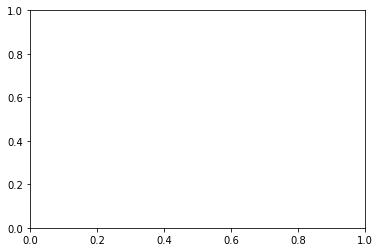

In [ ]:
difference = 17.5

bces = []

for start in range(18, 100, 1):
  output1 = torch.tensor([(start-difference) / 100.0])
  output2 = torch.tensor([(start/100.0)])

  bce_loss = BCELoss()(output1, output2).cpu().numpy()
  print (bce_loss)
  bces.append(bce_loss)

sns.lineplot(range(18, 100, 1), bces)

In [ ]:
def to_tensor(img):
    transform_fn = transforms.Compose([transforms.Resize(249, 3), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_small_distilled_patch16_224-649709d9.pth" to /root/.cache/torch/hub/checkpoints/deit_small_distilled_patch16_224-649709d9.pth


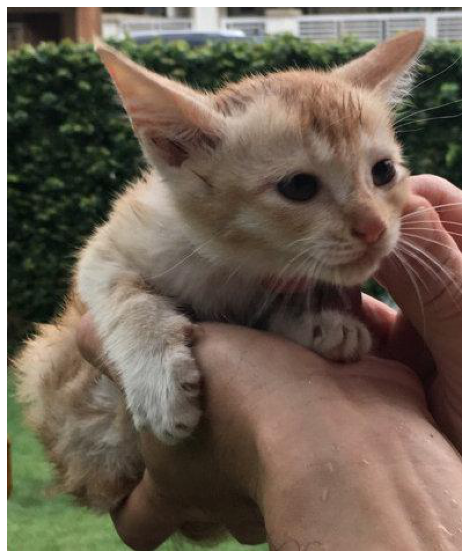

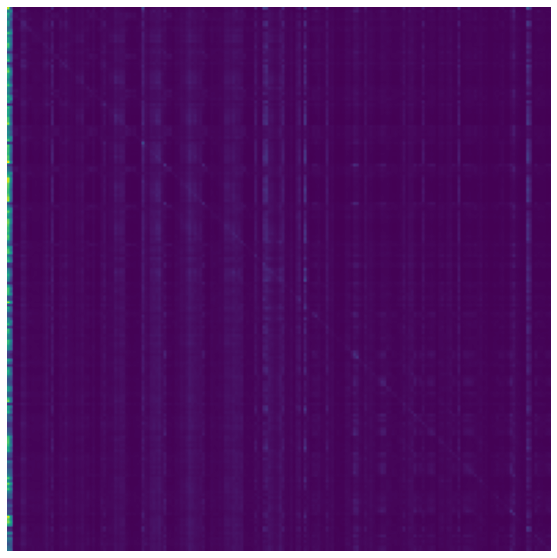

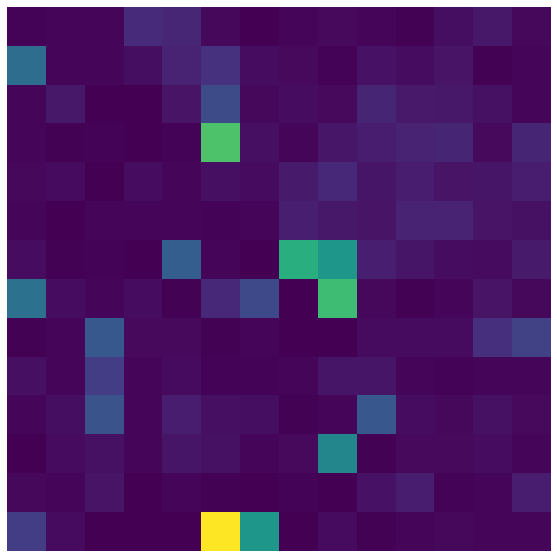

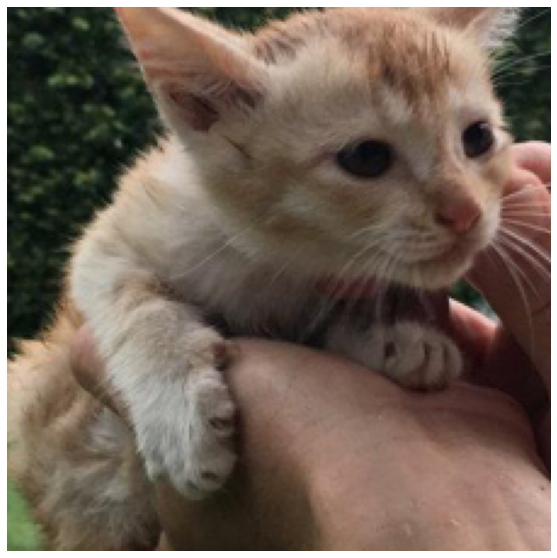

TypeError: ignored

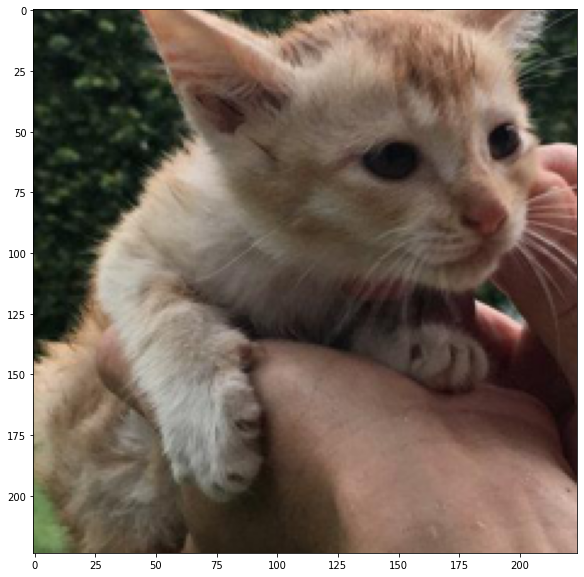

In [ ]:
from PIL import Image
import torch.nn.functional as F


img = Image.open(dataset_path + "/train/0a0da090aa9f0342444a7df4dc250c66.jpg")
x = to_tensor(img)

model = timm.create_model('deit_small_distilled_patch16_224', pretrained=True)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)